# Missing joints correlation matrix for JAAD + OpenPose

In the dataset used to make the predictions of crossing/not-crossing, in most pedestrian skeletons there are more than 3 undetected joints (whose coordinates are set to 0). This leads to lower than desired classification results. Even many skeletons in the dataset have not been detected and the coordinates of all its joints are set to 0, which is impossible to predict correctly since the skeleton is not detected. To try to improve this dataset, a denoising autoencoder is proposed in order to recover the missing joints. This notebook first analyzes which joints are missing and what correlation there is between the joints that are missing at the same time in the same skeleton, to propose a targeted denoising instead of a random denoising in another notebook.

In [2]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *

import cv2
from PIL import Image

import pandas as pd
import seaborn as sns

## Loading the skeletons dataset

In [3]:
datasetName = "JAAD"
subset = 'test'
numberOfClasses = 2
info = 1

dataset = SkeletonsDataset('Data/' + datasetName + '/' + subset + '_annotations_with_skeletons.csv', normalization='minmax', target='cross', info=info, remove_undetected=False)

In [4]:
dataset.loadedData[['video','frame','skeleton','cross']]

,video,frame,skeleton,cross
0,video_0001,0,"[[1448.57, 674.503, 0.924437], [1442.74, 698.0...",not-crossing
1,video_0001,1,"[[1451.47, 674.493, 0.906491], [1445.66, 698.0...",not-crossing
2,video_0001,2,"[[1451.58, 674.604, 0.856983], [1448.49, 698.0...",not-crossing
3,video_0001,3,"[[1457.41, 677.444, 0.82119], [1448.66, 698.11...",not-crossing
4,video_0001,4,"[[1466.12, 677.516, 0.846119], [1451.56, 700.9...",not-crossing
...,...,...,...,...
5559,video_0039,355,"[[0.0, 0.0, 0.0], [609.777, 795.251, 0.774795]...",crossing
5560,video_0039,356,"[[595.029, 771.685, 0.15024], [600.952, 795.13...",crossing
5561,video_0039,357,"[[0.0, 0.0, 0.0], [597.887, 795.25, 0.869133],...",crossing
5562,video_0039,358,"[[0.0, 0.0, 0.0], [592.049, 792.265, 0.860434]...",crossing


### Number of skeletons in which each joint is missing:

In [5]:
body_parts_names = {jointID: jointName for jointName, jointID in dataset.body_parts.items()}

body_parts_names

{0: 'Nose',
 1: 'Neck',
 2: 'RShoulder',
 3: 'RElbow',
 4: 'RWrist',
 5: 'LShoulder',
 6: 'LElbow',
 7: 'LWrist',
 8: 'MidHip',
 9: 'RHip',
 10: 'RKnee',
 11: 'RAnkle',
 12: 'LHip',
 13: 'LKnee',
 14: 'LAnkle',
 15: 'REye',
 16: 'LEye',
 17: 'REar',
 18: 'LEar',
 19: 'LBigToe',
 20: 'LSmallToe',
 21: 'LHeel',
 22: 'RBigToe',
 23: 'RSmallToe',
 24: 'RHeel'}

In [6]:
missing_joints_dic = {jointName: 0 for jointName, jointID in dataset.body_parts.items()}

missing_joints_dic

{'Nose': 0,
 'Neck': 0,
 'RShoulder': 0,
 'RElbow': 0,
 'RWrist': 0,
 'LShoulder': 0,
 'LElbow': 0,
 'LWrist': 0,
 'MidHip': 0,
 'RHip': 0,
 'RKnee': 0,
 'RAnkle': 0,
 'LHip': 0,
 'LKnee': 0,
 'LAnkle': 0,
 'REye': 0,
 'LEye': 0,
 'REar': 0,
 'LEar': 0,
 'LBigToe': 0,
 'LSmallToe': 0,
 'LHeel': 0,
 'RBigToe': 0,
 'RSmallToe': 0,
 'RHeel': 0}

In [7]:
for data_i in range(0, len(dataset.data)):
    missing_joints_in_skeleton = np.where(np.sum(dataset.data[data_i].x_temporal[0].numpy(), axis=1) == 0)[0]
    
    for missing_joint in missing_joints_in_skeleton:
        missing_joints_dic[body_parts_names[missing_joint]] = missing_joints_dic[body_parts_names[missing_joint]] + 1
        
missing_joints_dic

{'Nose': 1854,
 'Neck': 999,
 'RShoulder': 993,
 'RElbow': 1077,
 'RWrist': 1269,
 'LShoulder': 1016,
 'LElbow': 1136,
 'LWrist': 1543,
 'MidHip': 1016,
 'RHip': 1018,
 'RKnee': 1090,
 'RAnkle': 1239,
 'LHip': 1023,
 'LKnee': 1089,
 'LAnkle': 1222,
 'REye': 2324,
 'LEye': 2585,
 'REar': 1502,
 'LEar': 1827,
 'LBigToe': 1567,
 'LSmallToe': 1612,
 'LHeel': 1263,
 'RBigToe': 1361,
 'RSmallToe': 1378,
 'RHeel': 1270}

In [8]:
missing_joints_df = pd.DataFrame(missing_joints_dic.items(), columns=['Joint', 'Number of skeletons in which is missing'])

missing_joints_df

,Joint,Number of skeletons in which is missing
0,Nose,1854
1,Neck,999
2,RShoulder,993
3,RElbow,1077
4,RWrist,1269
5,LShoulder,1016
6,LElbow,1136
7,LWrist,1543
8,MidHip,1016
9,RHip,1018


### Correlation matrix of missing joints

If joint Y is missing, amount of times that joint X is also missing:

In [9]:
corr = np.zeros((len(dataset.body_parts), len(dataset.body_parts)))

In [10]:
for jointName, jointID in dataset.body_parts.items():
    
    for data_i in range(0, len(dataset.data)):

        missing_joints_in_skeleton = np.where(np.sum(dataset.data[data_i].x_temporal[0].numpy(), axis=1) == 0)[0]
        
        if jointID in missing_joints_in_skeleton:

            for missing_joint in missing_joints_in_skeleton:
                
                corr[jointID][missing_joint] = corr[jointID][missing_joint] + 1
                
corr_df = pd.DataFrame(corr, columns=dataset.body_parts.keys(), index=dataset.body_parts.keys())
corr_df

,Nose,Neck,RShoulder,RElbow,RWrist,LShoulder,LElbow,LWrist,MidHip,RHip,...,REye,LEye,REar,LEar,LBigToe,LSmallToe,LHeel,RBigToe,RSmallToe,RHeel
Nose,1854.0,995.0,982.0,1011.0,1055.0,1004.0,1018.0,1068.0,982.0,977.0,...,1796.0,1814.0,1062.0,1082.0,1049.0,1068.0,993.0,1017.0,1023.0,1015.0
Neck,995.0,999.0,974.0,976.0,976.0,990.0,989.0,990.0,983.0,976.0,...,995.0,995.0,985.0,996.0,978.0,978.0,976.0,981.0,982.0,980.0
RShoulder,982.0,974.0,993.0,993.0,993.0,971.0,974.0,976.0,961.0,954.0,...,984.0,983.0,988.0,982.0,963.0,963.0,958.0,963.0,964.0,962.0
RElbow,1011.0,976.0,993.0,1077.0,1077.0,979.0,1000.0,1012.0,972.0,968.0,...,1036.0,1012.0,1043.0,1000.0,1015.0,1018.0,1007.0,1016.0,1017.0,1013.0
RWrist,1055.0,976.0,993.0,1077.0,1269.0,982.0,1011.0,1062.0,975.0,973.0,...,1137.0,1065.0,1121.0,1022.0,1075.0,1085.0,1052.0,1077.0,1079.0,1069.0
LShoulder,1004.0,990.0,971.0,979.0,982.0,1016.0,1015.0,1015.0,979.0,973.0,...,1005.0,1008.0,997.0,1011.0,987.0,987.0,980.0,985.0,986.0,984.0
LElbow,1018.0,989.0,974.0,1000.0,1011.0,1015.0,1136.0,1136.0,999.0,994.0,...,1017.0,1082.0,1017.0,1080.0,1027.0,1028.0,1017.0,1024.0,1025.0,1018.0
LWrist,1068.0,990.0,976.0,1012.0,1062.0,1015.0,1136.0,1543.0,1001.0,998.0,...,1069.0,1380.0,1046.0,1227.0,1086.0,1096.0,1051.0,1083.0,1084.0,1066.0
MidHip,982.0,983.0,961.0,972.0,975.0,979.0,999.0,1001.0,1016.0,1009.0,...,982.0,990.0,985.0,990.0,1008.0,1008.0,1006.0,1010.0,1010.0,1009.0
RHip,977.0,976.0,954.0,968.0,973.0,973.0,994.0,998.0,1009.0,1018.0,...,980.0,985.0,984.0,985.0,1007.0,1007.0,1005.0,1018.0,1018.0,1018.0


Text(0.5, 1.0, 'Missing joints correlation heatmap')

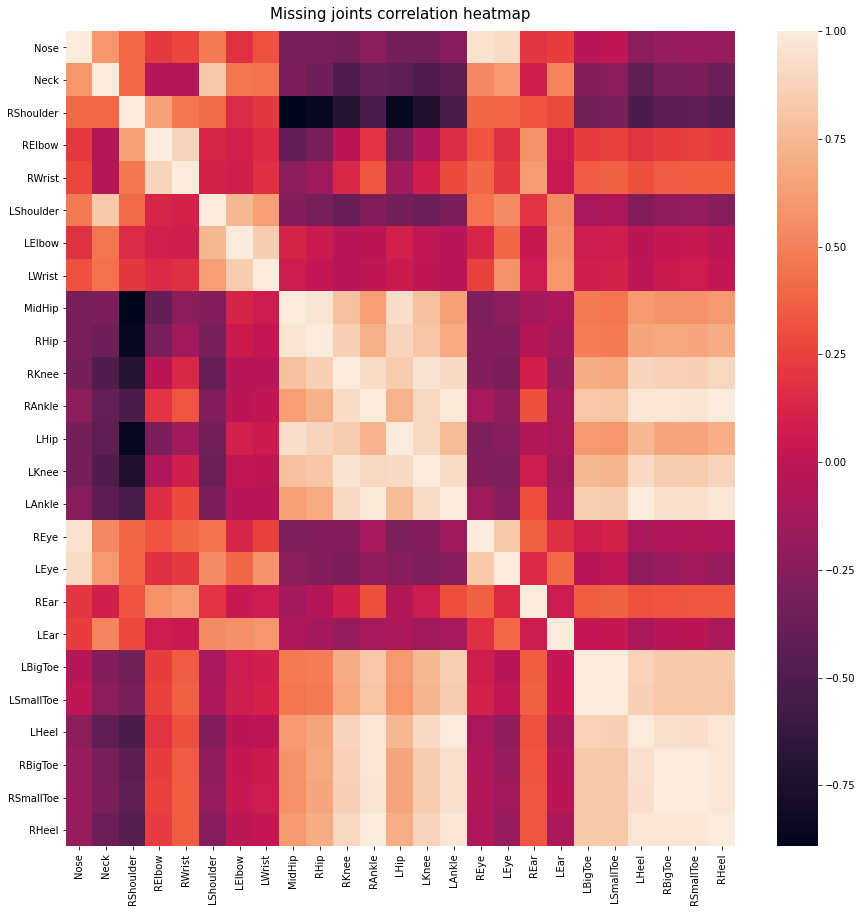

In [11]:
corr_mat = corr_df.corr()

plt.figure(figsize=(15,15))
heatmap = sns.heatmap(corr_mat)
heatmap.set_title('Missing joints correlation heatmap', fontdict={'fontsize': 15}, pad=12)

## Grouping joints that are commonly missing at the same time in a same skeleton:

In [12]:
corr_mat_np = corr_mat.to_numpy()

groups = []

for i in range(corr_mat_np.shape[0]):
    
    group = []
    
    for j in range(corr_mat_np.shape[1]):
        
        if corr_mat_np[i, j] > 0.8:
            group.append(body_parts_names[j])
     
    if len(group) > 1:
        if group not in groups:
            groups.append(group)
    
groups

[['Nose', 'REye', 'LEye'],
 ['Neck', 'LShoulder'],
 ['RElbow', 'RWrist'],
 ['LElbow', 'LWrist'],
 ['MidHip', 'RHip', 'LHip'],
 ['MidHip', 'RHip', 'RKnee', 'LHip', 'LKnee'],
 ['RHip',
  'RKnee',
  'RAnkle',
  'LHip',
  'LKnee',
  'LAnkle',
  'LHeel',
  'RBigToe',
  'RSmallToe',
  'RHeel'],
 ['RKnee',
  'RAnkle',
  'LKnee',
  'LAnkle',
  'LBigToe',
  'LSmallToe',
  'LHeel',
  'RBigToe',
  'RSmallToe',
  'RHeel'],
 ['RAnkle',
  'LAnkle',
  'LBigToe',
  'LSmallToe',
  'LHeel',
  'RBigToe',
  'RSmallToe',
  'RHeel']]

In [13]:
    def showSkeleton(dataset, videoNum=0, frameNum=0, textSize=14, showLegend=True, frameImage=None, normalizedSkeletons=True, 
                     title='Skeleton preview in 2D', show=True, prediction=None, groundtruth=None, highlighted=None, ax=None):
        
        parts = list(dataset.body_parts.keys())

        node_coords = {}
            
        use_new_ax = ax is None
        
        if ax is None:
            fig = plt.figure(figsize=(10,10)) if show else Figure(figsize=(10,10))

            ax = fig.add_subplot(1, 1, 1)

        if normalizedSkeletons:
            skeleton = dataset.data[videoNum].x_temporal[frameNum][:, 0:2].tolist()
        else:
            skeleton = dataset.original_skeletons[videoNum][frameNum][:, 0:2].tolist()

        for e, sk in enumerate(skeleton):    
            node_coords[parts[e]] = sk

            if highlighted is None:
                ax.scatter(sk[0], sk[1], label=parts[e])
            else:
                ax.scatter(sk[0], sk[1], label=parts[e], color='green' if parts[e] in highlighted else 'red')

        for edge in dataset.pose_parts:
            e0 = node_coords[edge[0]]
            e1 = node_coords[edge[1]]

            ax.plot([e0[0], e1[0]], [e0[1], e1[1]], color='gray')

            
        if showLegend:
            ax.legend(loc='best', prop={'size': 11})
            
        if frameImage is not None:
            ax.imshow(frameImage)
        
        if show:
            plt.xticks(size=textSize)
            plt.yticks(size=textSize)
            plt.title(title, size=textSize)
            
        else:
            ax.set_title(title, size=textSize)
        
        if use_new_ax:
            if show:
                plt.show()
            else:
                return fig

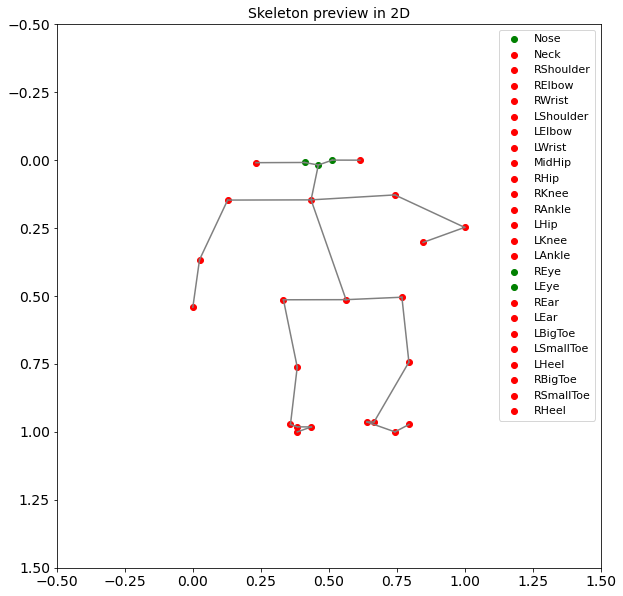

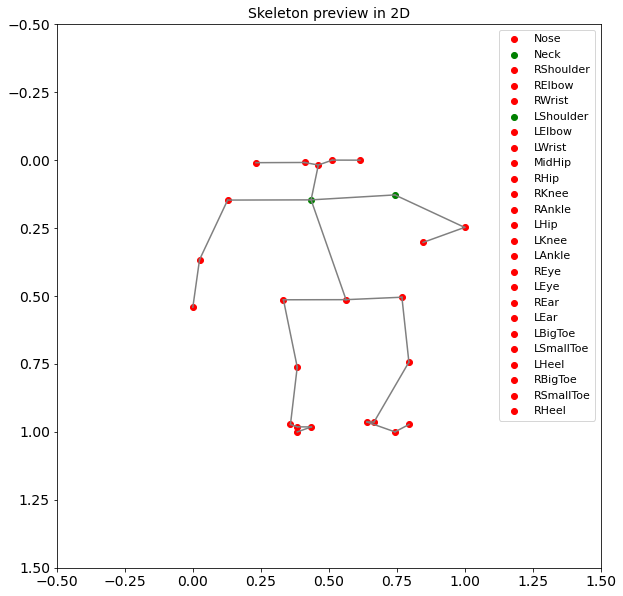

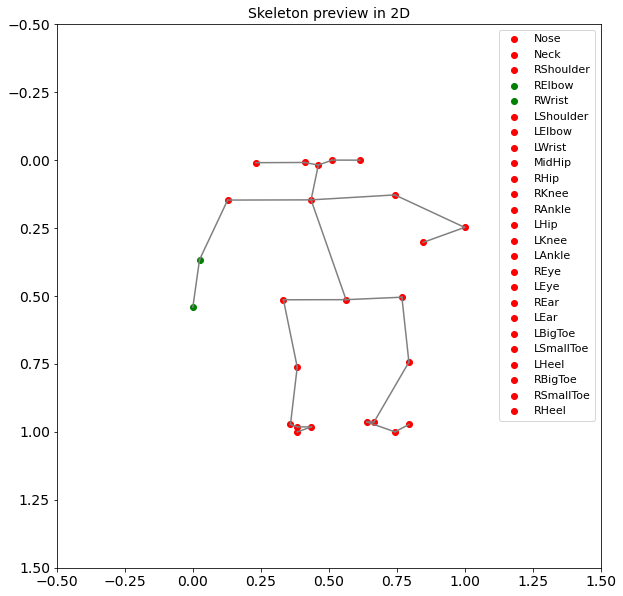

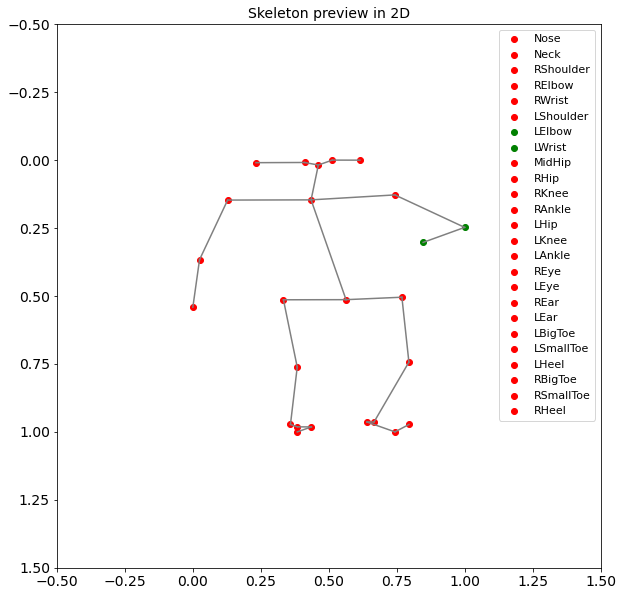

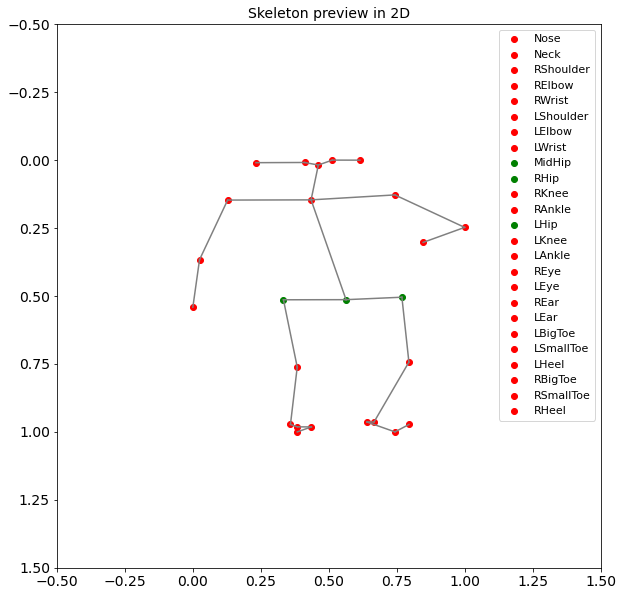

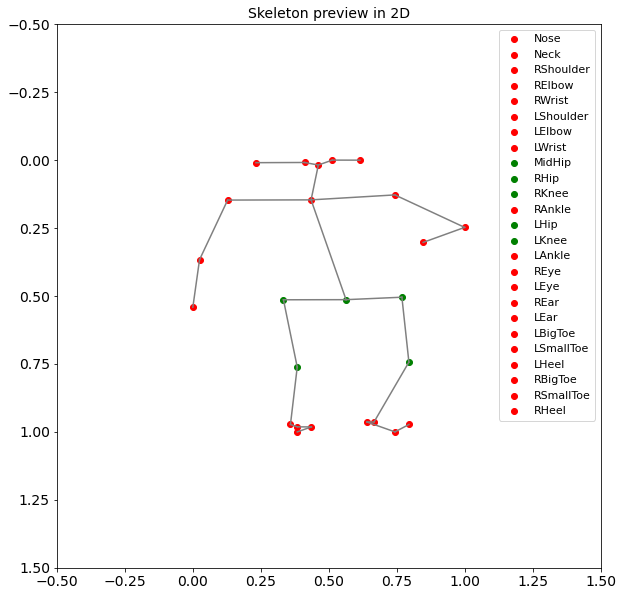

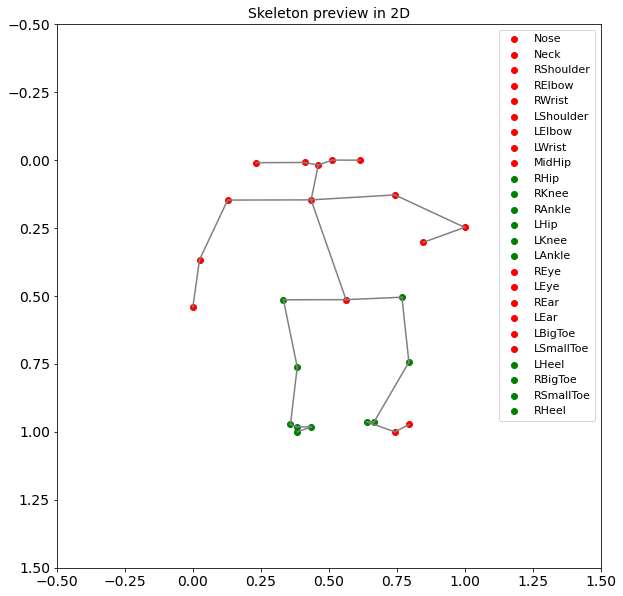

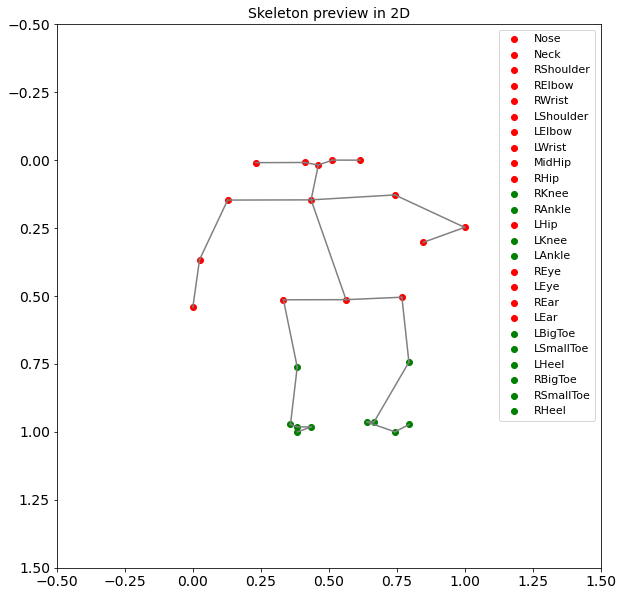

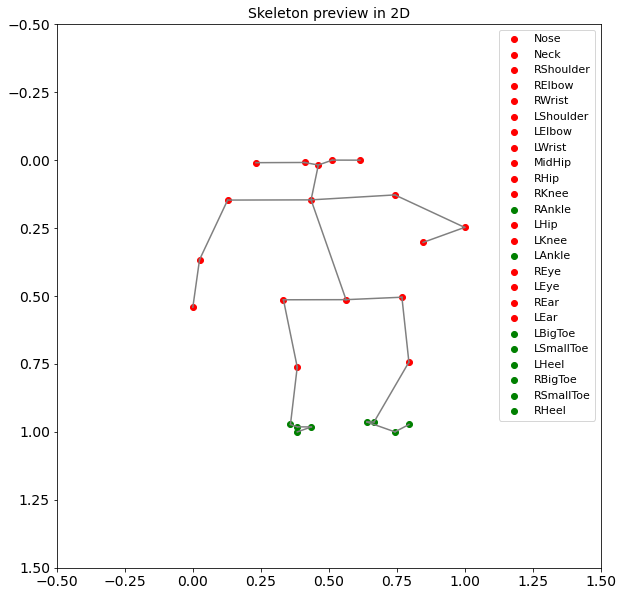

In [14]:
for group in groups:
    showSkeleton(dataset, 42, frameImage=np.ones((2,2,3)), highlighted=group)

# Map JAAD joints to CARLA

Map is needed to use the missing groups of joints information in JAAD to experiment in CARLA, in which we have the groundtruth of the pedestrian skeletons.

In [15]:
body_parts_jaad = {
    "Nose": 0,
    "Neck": 1,
    "RShoulder": 2,
    "RElbow": 3,
    "RWrist": 4,
    "LShoulder": 5,
    "LElbow": 6,
    "LWrist": 7,
    "MidHip": 8,
    "RHip": 9,
    "RKnee": 10,
    "RAnkle": 11,
    "LHip": 12,
    "LKnee": 13,
    "LAnkle": 14,
    "REye": 15,
    "LEye": 16,
    "REar": 17,
    "LEar": 18,
    "LBigToe": 19,
    "LSmallToe": 20,
    "LHeel": 21,
    "RBigToe": 22,
    "RSmallToe": 23,
    "RHeel": 24,
}

body_parts_carla = {
    "crl_root": 0,
    "crl_hips__C": 1,
    "crl_spine__C": 2,
    "crl_spine01__C": 3,
    "crl_shoulder__L": 4,
    "crl_arm__L": 5,
    "crl_foreArm__L": 6,
    "crl_hand__L": 7,
    "crl_neck__C": 8,
    "crl_Head__C": 9,
    "crl_eye__L": 10,
    "crl_eye__R": 11,
    "crl_shoulder__R": 12,
    "crl_arm__R": 13,
    "crl_foreArm__R": 14,
    "crl_hand__R": 15,
    "crl_thigh__R": 16,
    "crl_leg__R": 17,
    "crl_foot__R": 18,
    "crl_toe__R": 19,
    "crl_toeEnd__R": 20,
    "crl_thigh__L": 21,
    "crl_leg__L": 22,
    "crl_foot__L": 23,
    "crl_toe__L": 24,
    "crl_toeEnd__L": 25,                    
}

## Show carla skeleton

In [16]:
dataset_carla = SkeletonsDataset('Data/CARLA/test_preprocessed.csv', numberOfJoints=26,
                                 normalization='minmax', target='crossing', info=1, remove_undetected=False)

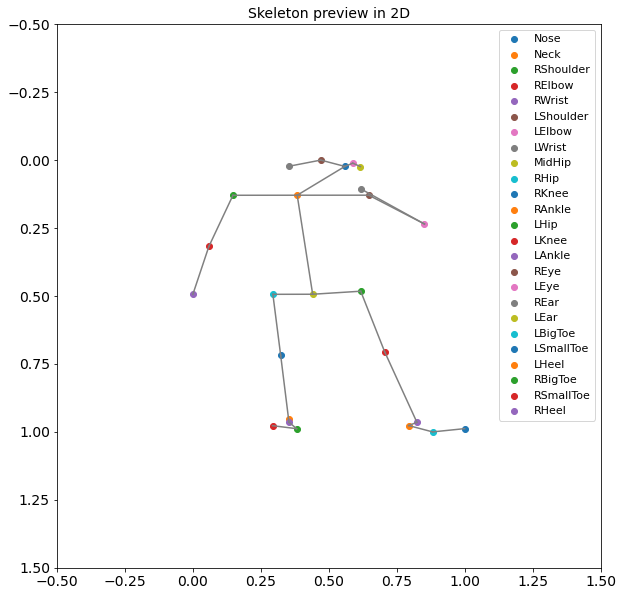

In [17]:
showSkeleton(dataset, 20, frameImage=np.ones((2,2,3)), highlighted=None) # JAAD skeleton

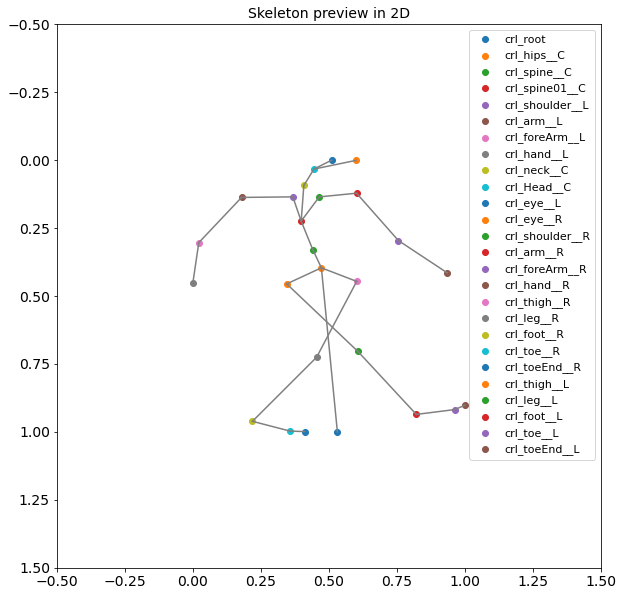

In [18]:
showSkeleton(dataset_carla, 20, frameImage=np.ones((2,2,3)), highlighted=None) # CARLA skeleton

In [19]:
map_jaad_to_carla = {
    'Nose': 'crl_Head__C',
    'REye': 'crl_eye__R',
    'LEye': 'crl_eye__L',
    'REar': 'crl_eye__R',
    'LEar': 'crl_eye__L',
    'Neck': 'crl_neck__C',
    'RShoulder': 'crl_shoulder__R',
    'LShoulder': 'crl_shoulder__L',
    'RElbow': 'crl_foreArm__R',
    'LElbow': 'crl_foreArm__L',
    'RWrist': 'crl_hand__R',
    'LWrist': 'crl_hand__L',
    'MidHip': 'crl_hips__C',
    'RHip': 'crl_thigh__R',
    'LHip': 'crl_thigh__L',
    'RKnee': 'crl_leg__R',
    'LKnee': 'crl_leg__L',
    'RAnkle': 'crl_foot__R',
    'LAnkle': 'crl_foot__L',
    'RHeel': 'crl_foot__R',
    'LHeel': 'crl_foot__L',
    'RBigToe': 'crl_toe__R',
    'LBigToe': 'crl_toe__L',
    'RSmallToe': 'crl_toeEnd__R',
    'LSmallToe': 'crl_toeEnd__L',
}

## Check mapping:

C:\Users\Abel\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


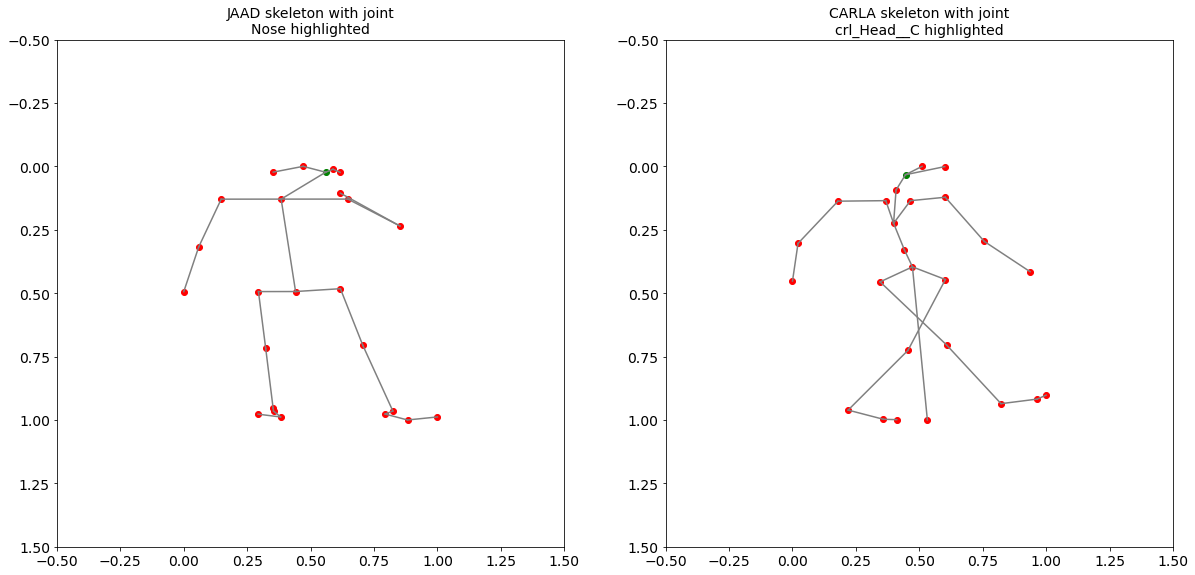

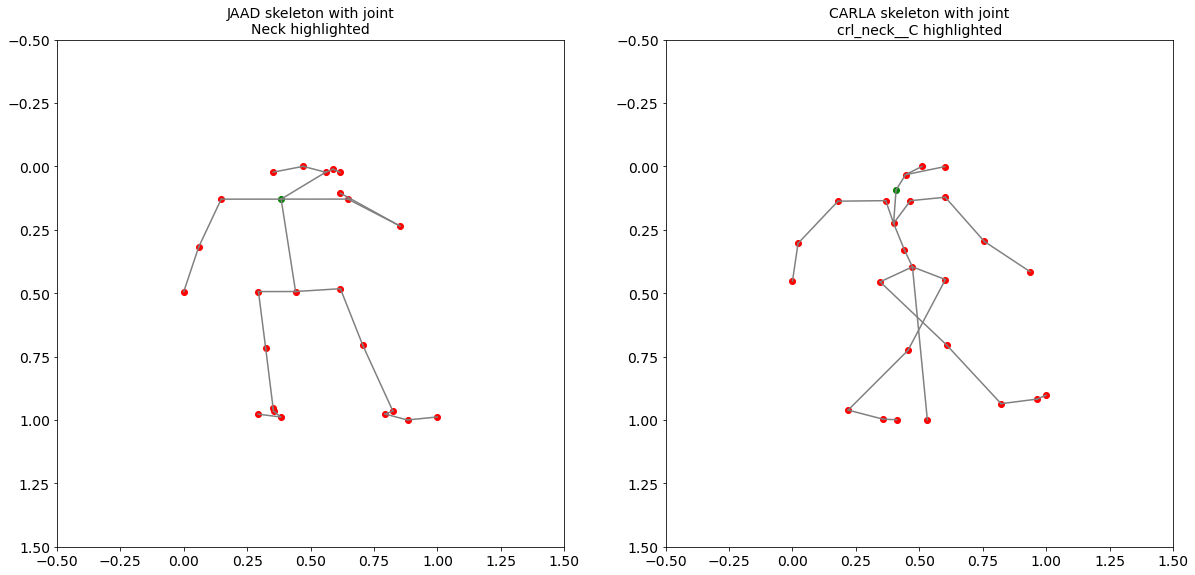

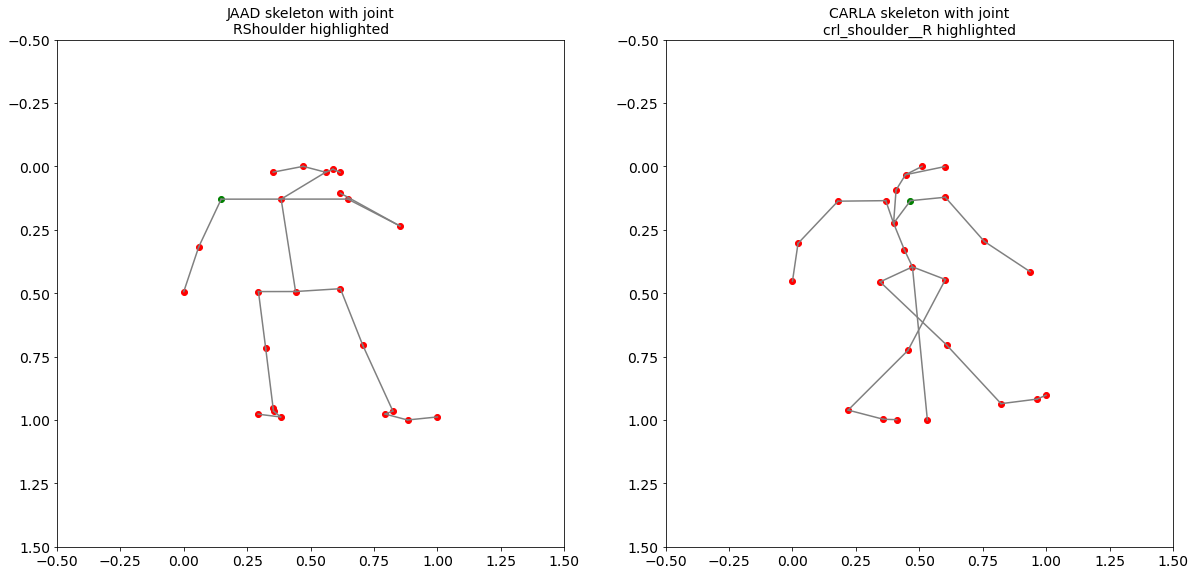

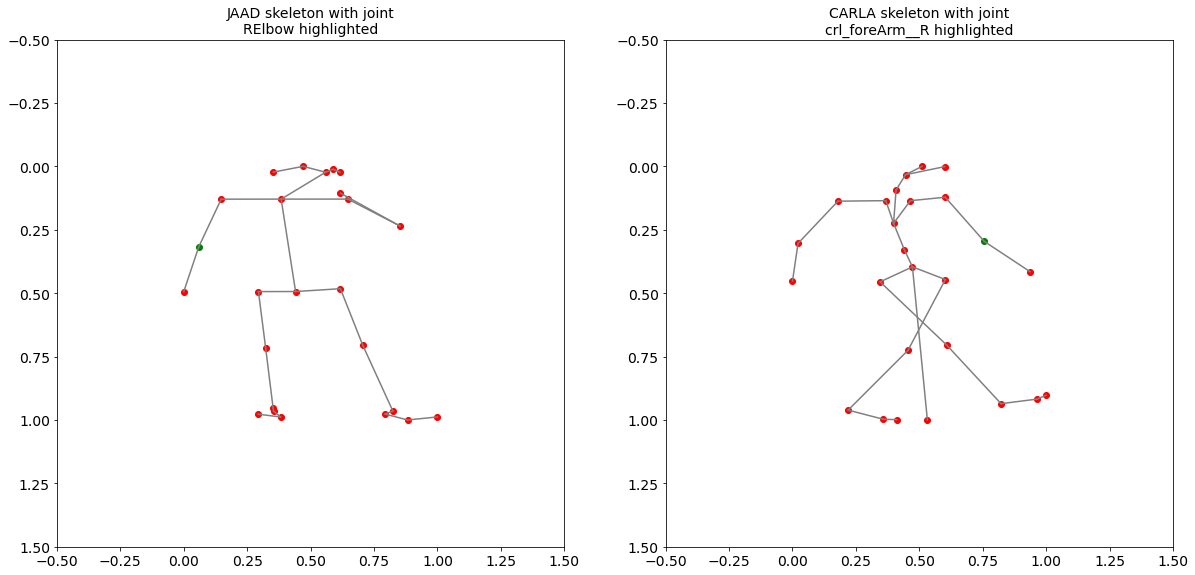

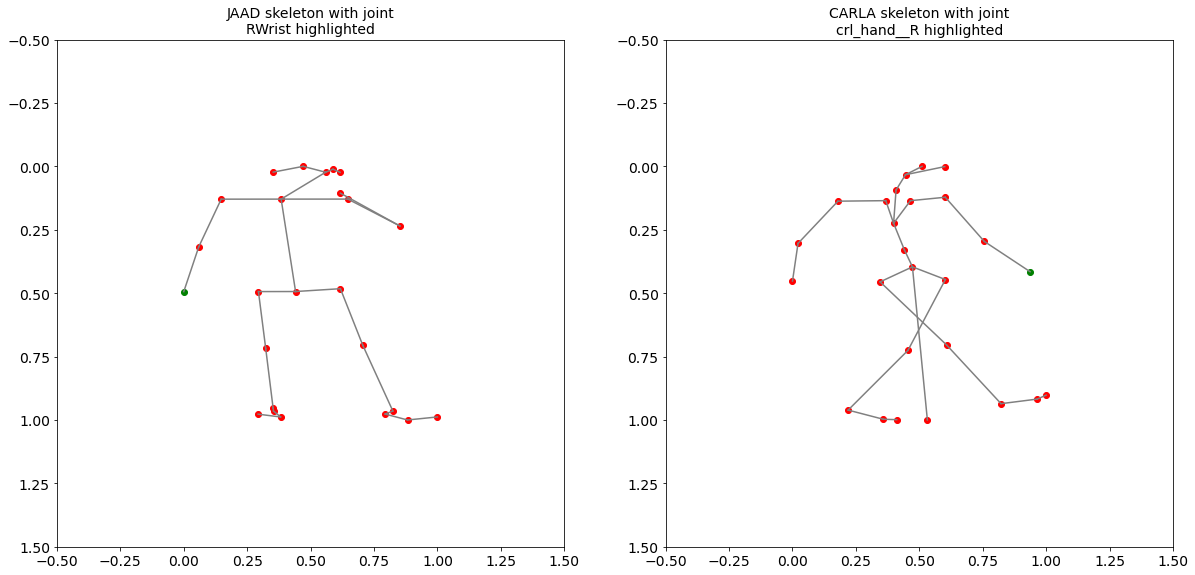

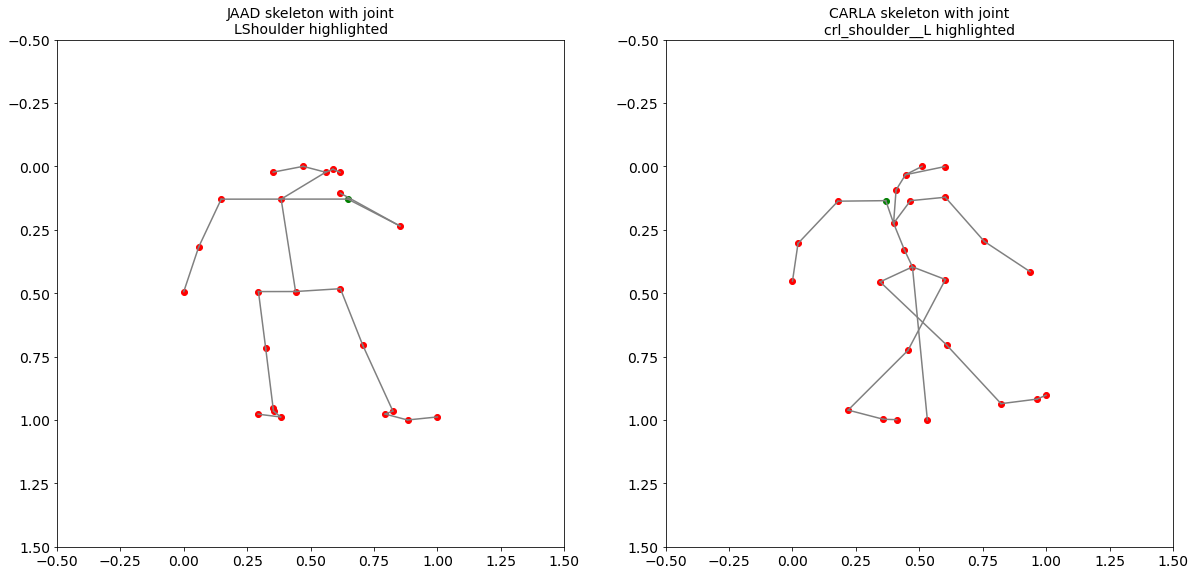

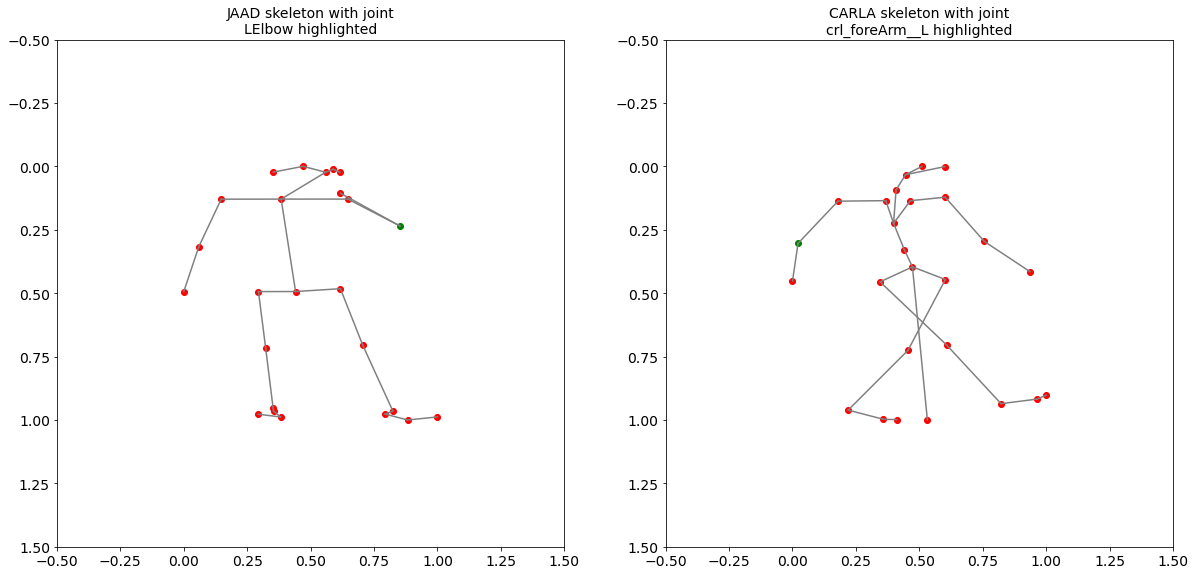

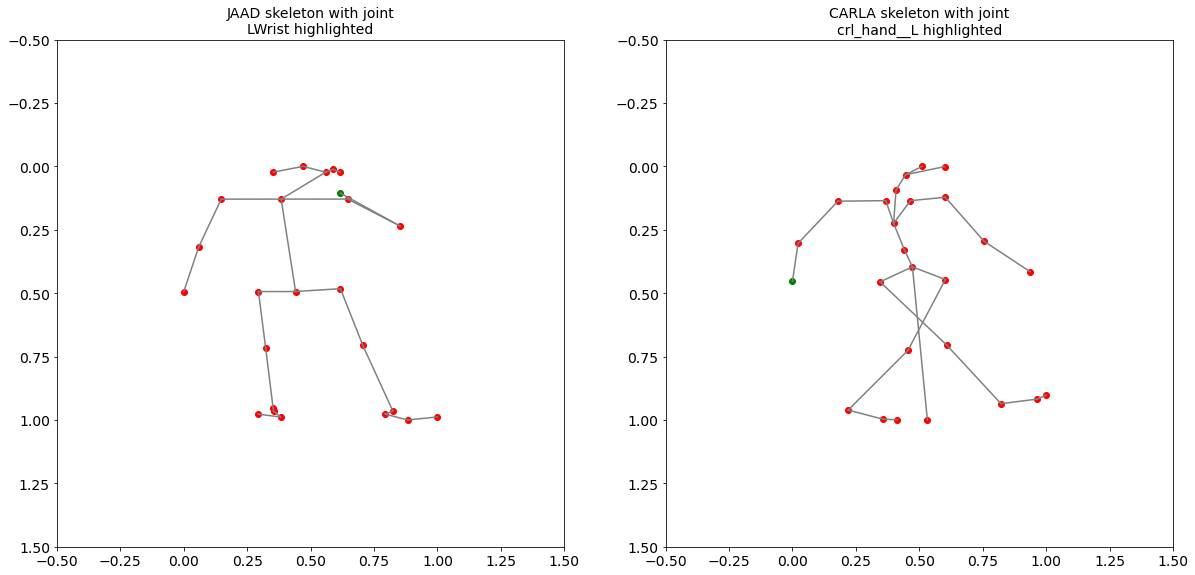

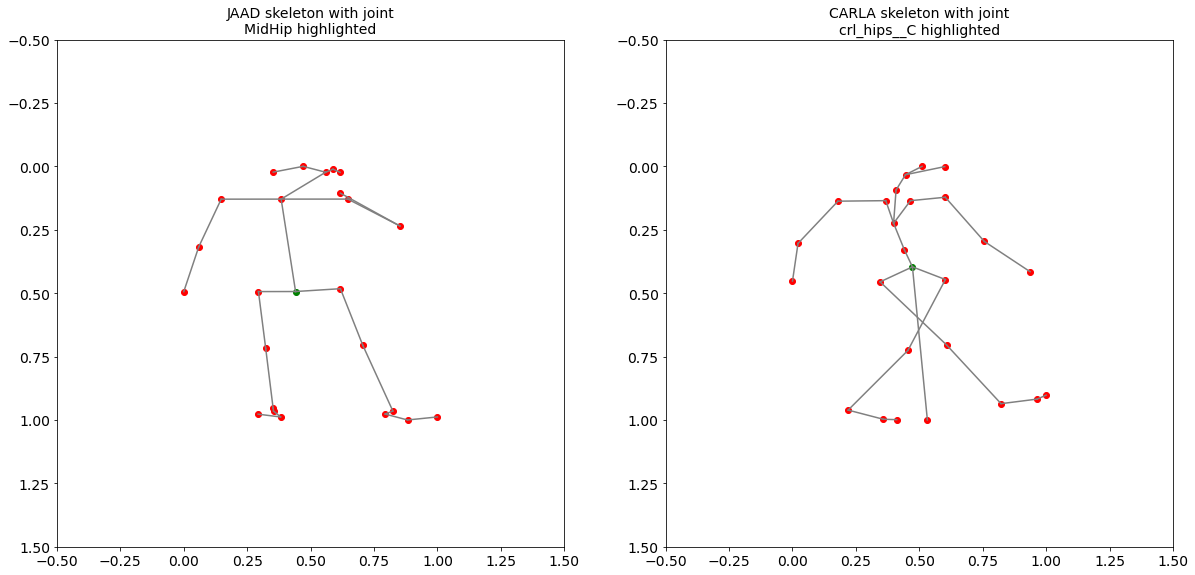

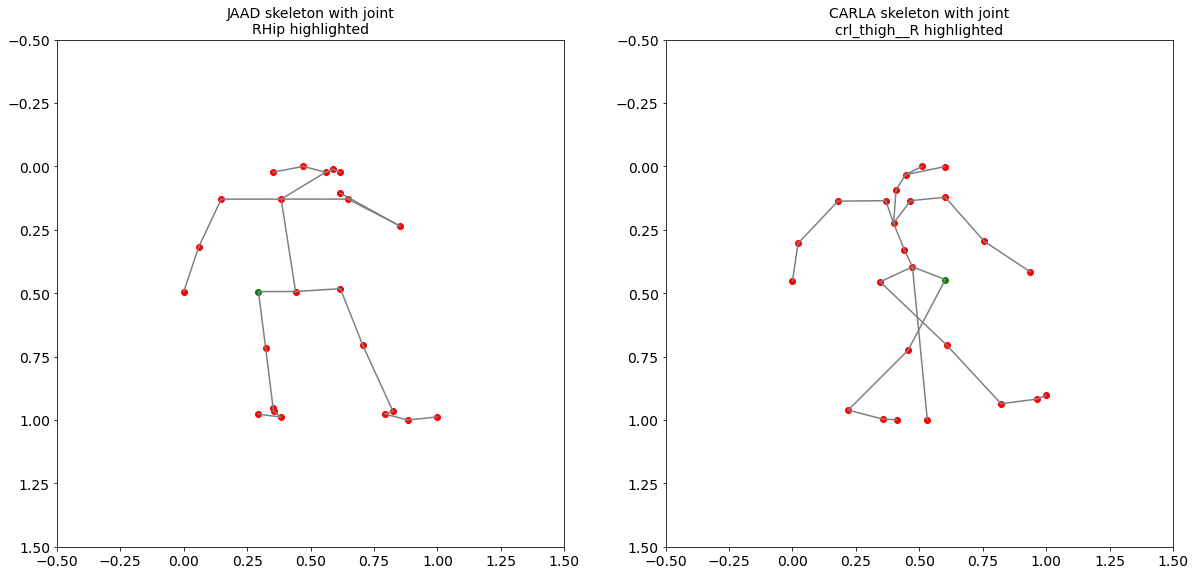

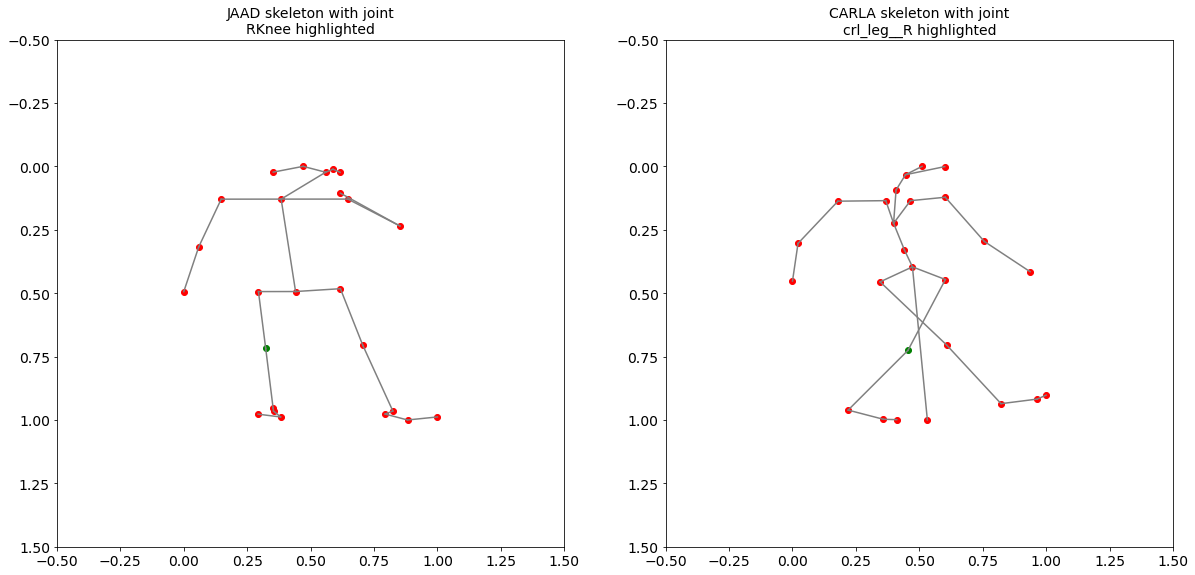

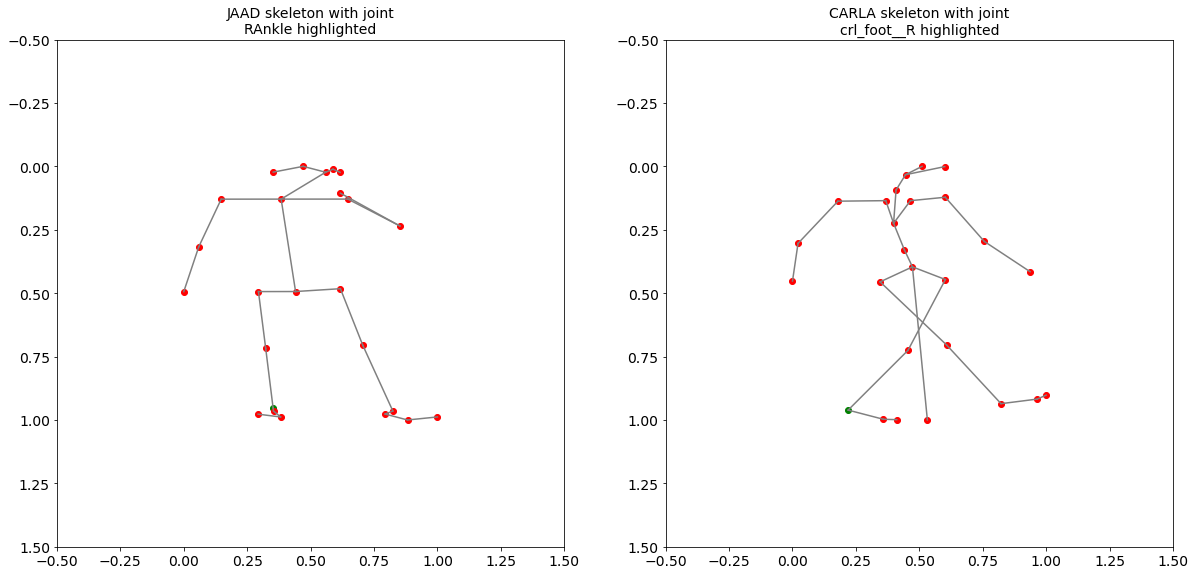

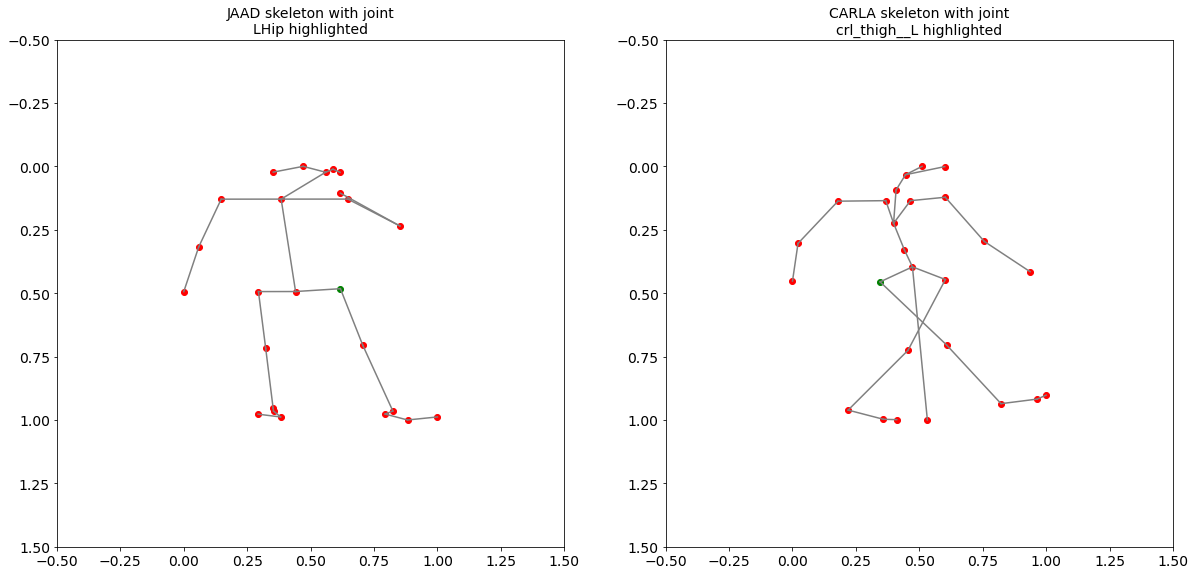

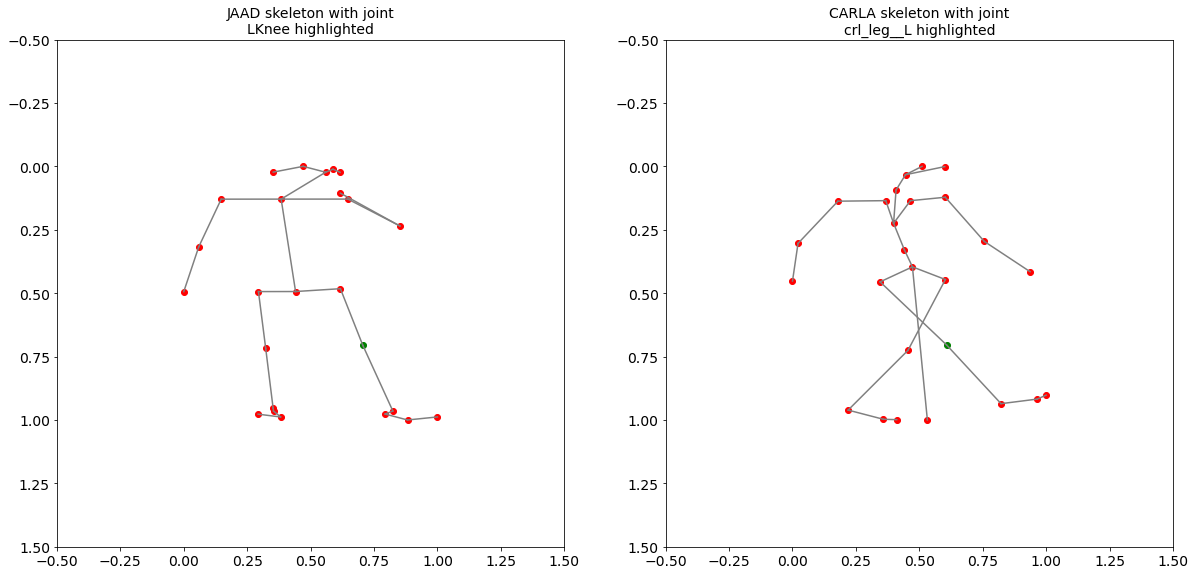

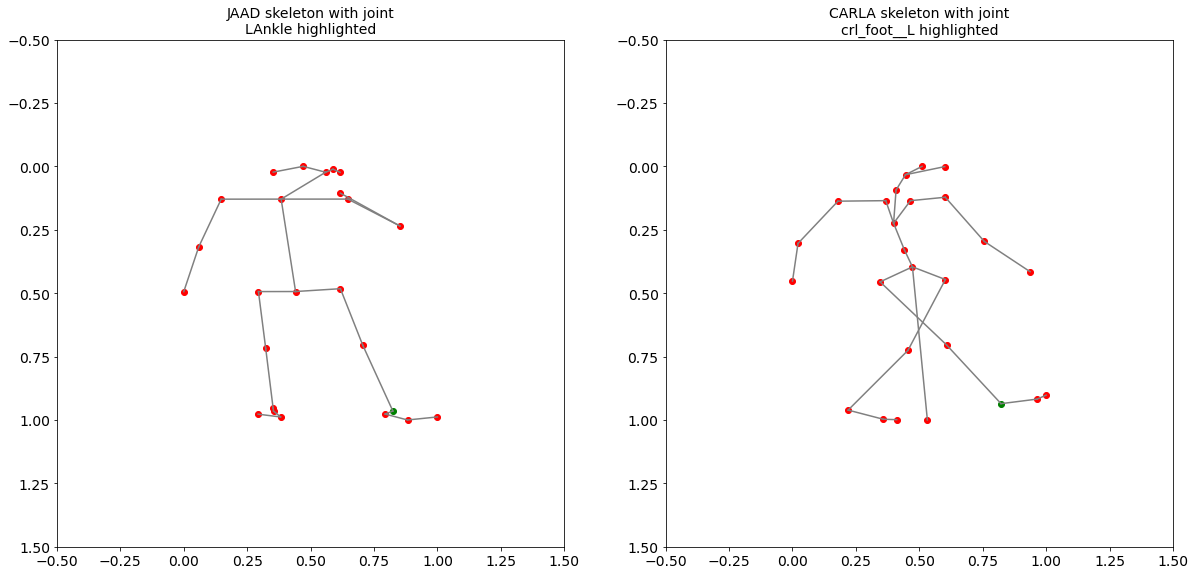

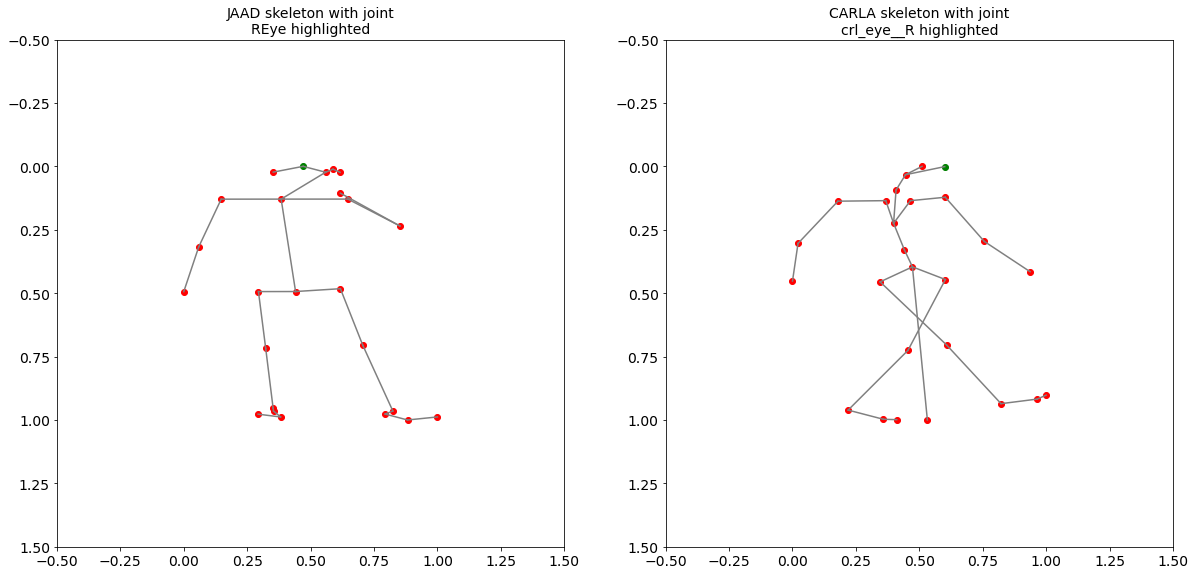

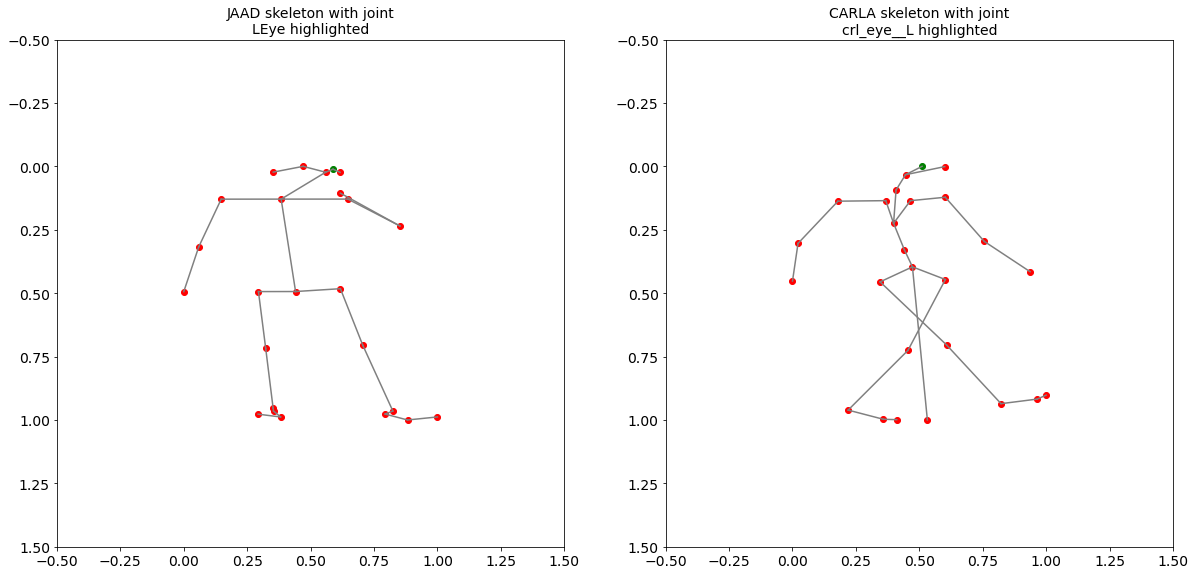

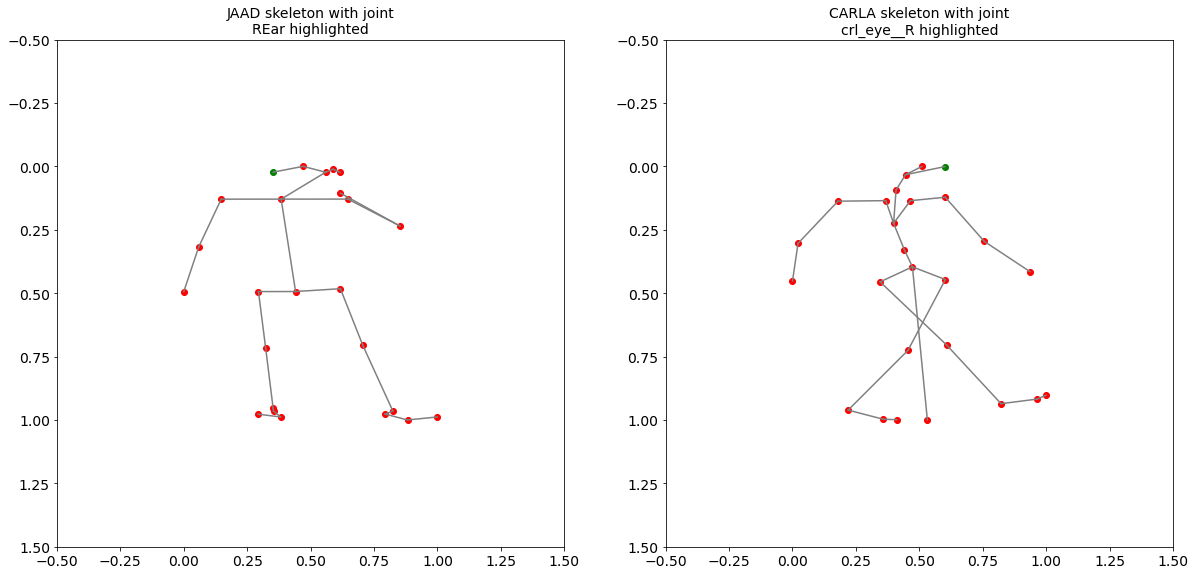

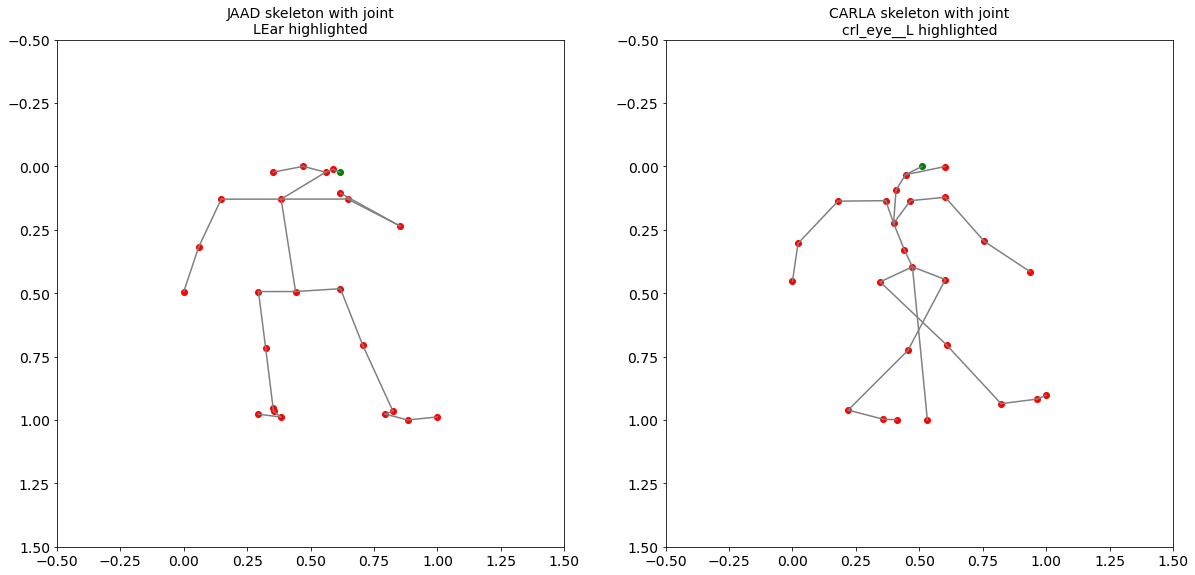

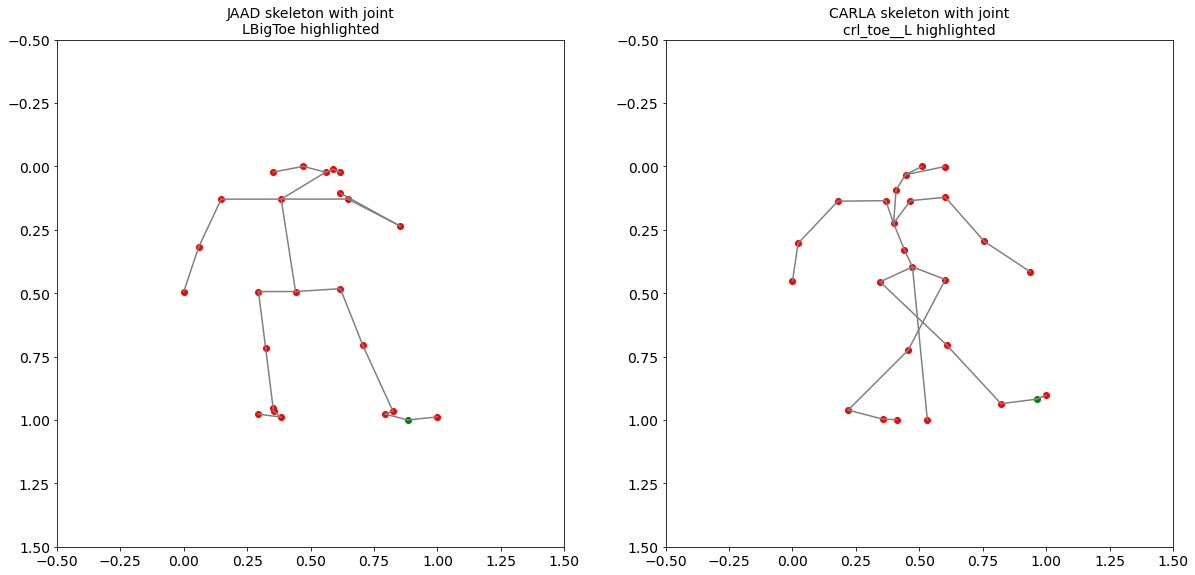

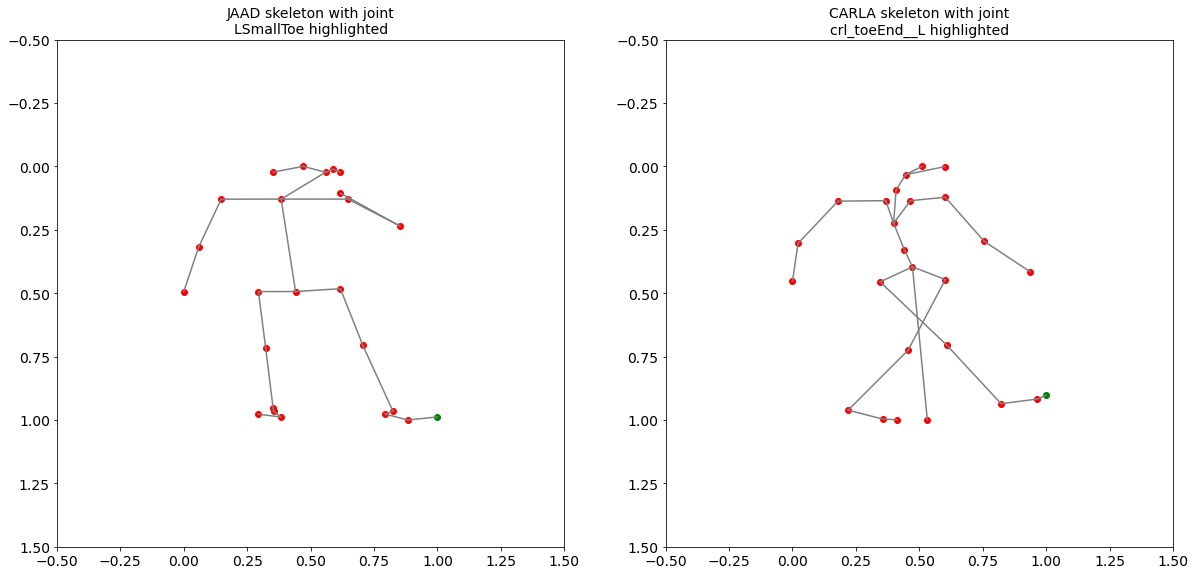

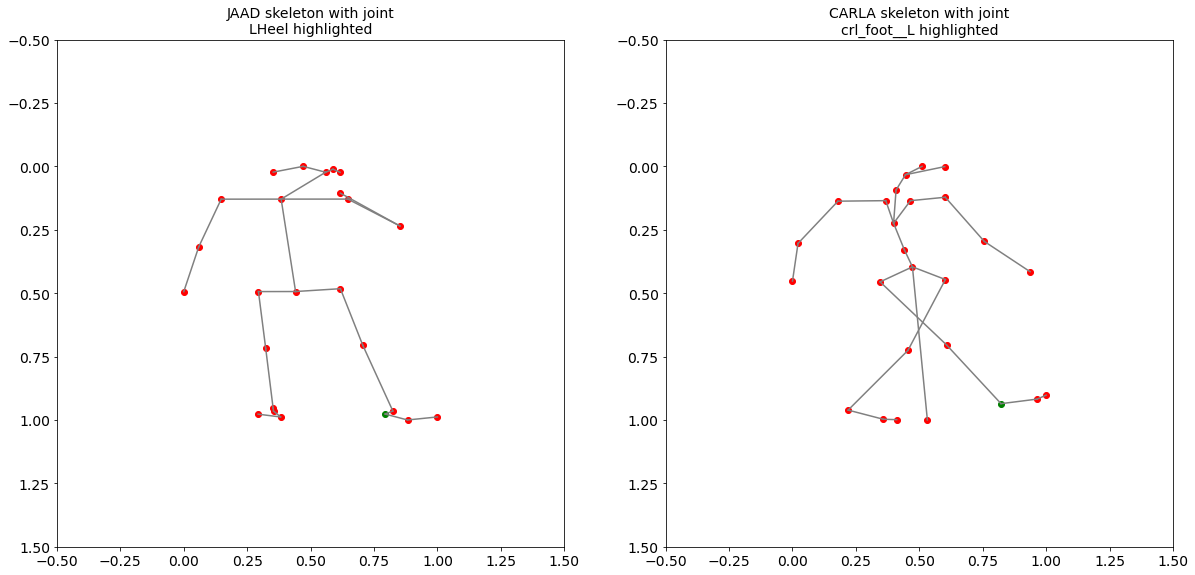

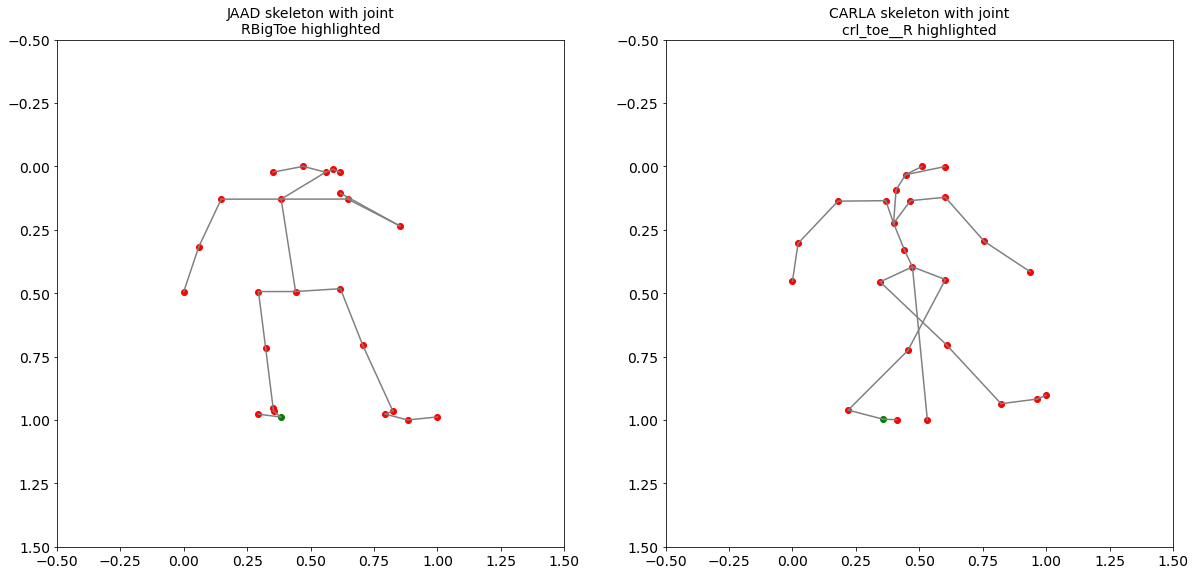

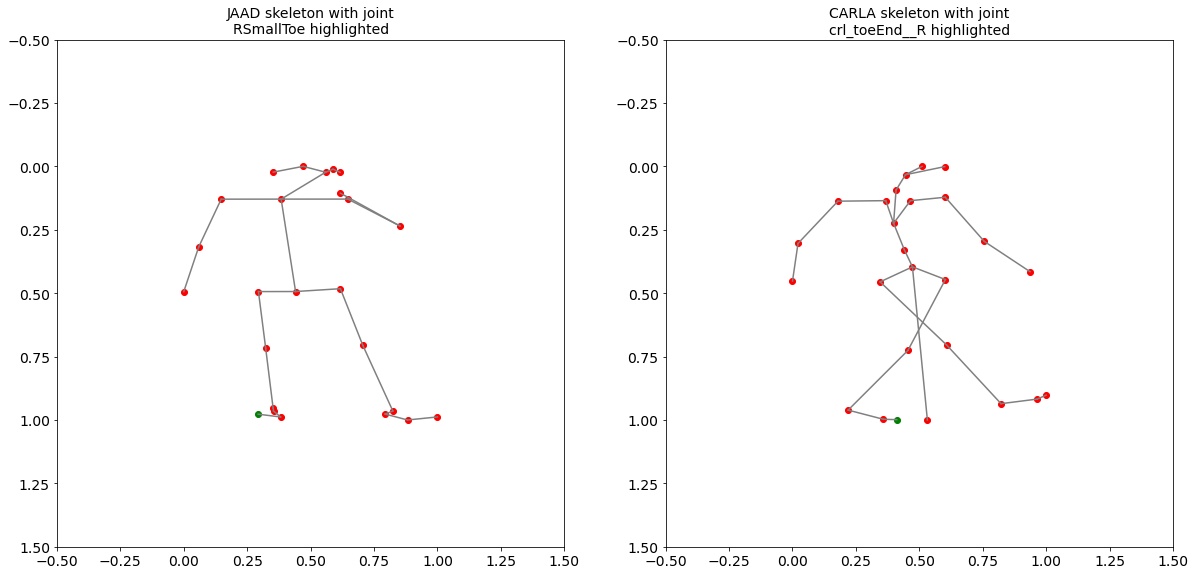

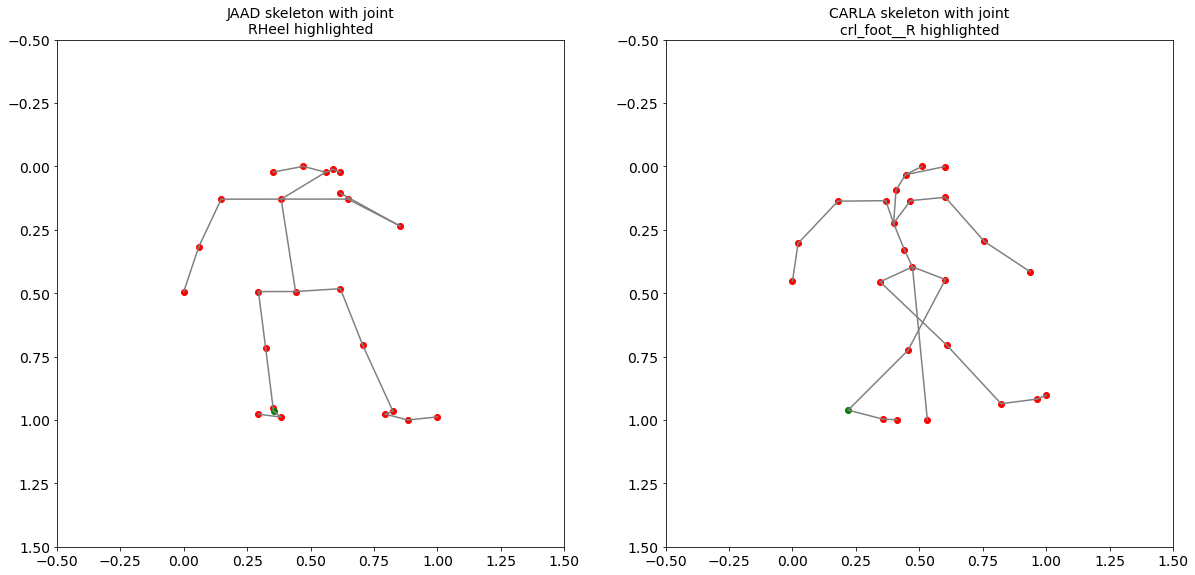

In [23]:
for joint in body_parts_jaad.keys():
    fig = plt.figure(figsize=(20,20))

    ax1 = fig.add_subplot(1,2,1)
    showSkeleton(dataset, 20, frameImage=np.ones((2,2,3)), highlighted=[joint], 
                 ax=ax1, showLegend=False, title='JAAD skeleton with joint\n' + joint + ' highlighted')

    ax2 = fig.add_subplot(1,2,2)
    showSkeleton(dataset_carla, 20, frameImage=np.ones((2,2,3)), highlighted=[map_jaad_to_carla[joint]],
                 ax=ax2, showLegend=False, title='CARLA skeleton with joint\n' + map_jaad_to_carla[joint] + ' highlighted')

## See groups of common missing joints but mapped to CARLA:

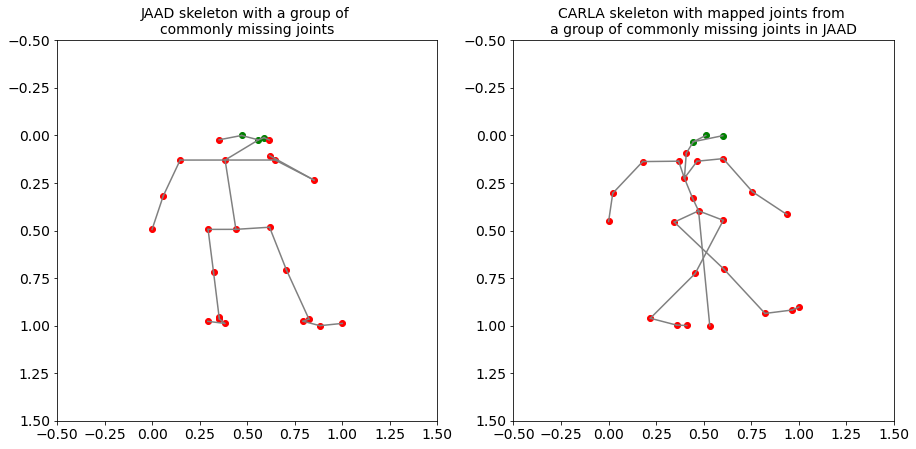

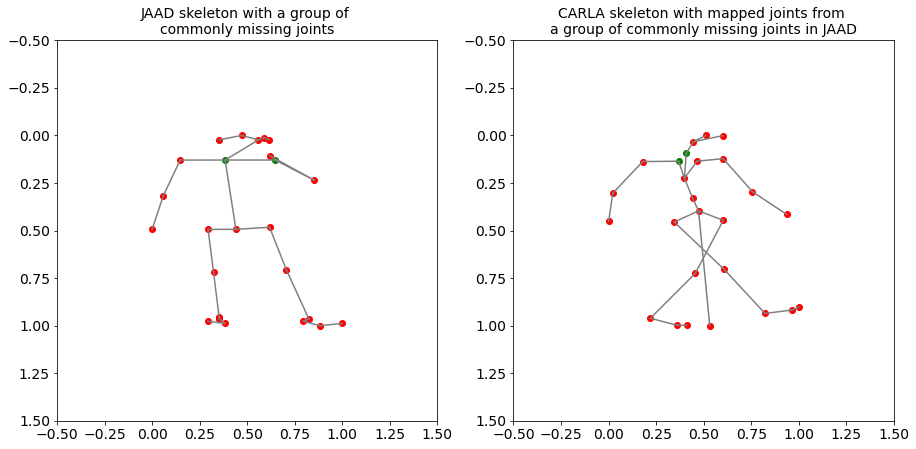

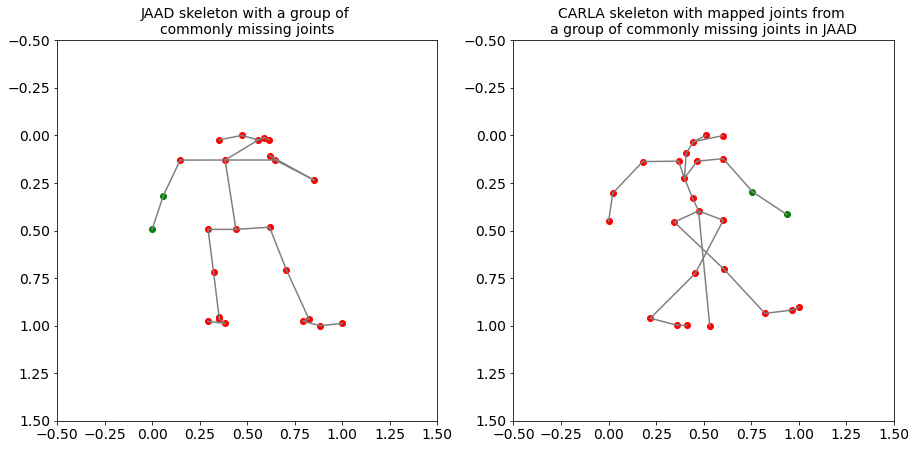

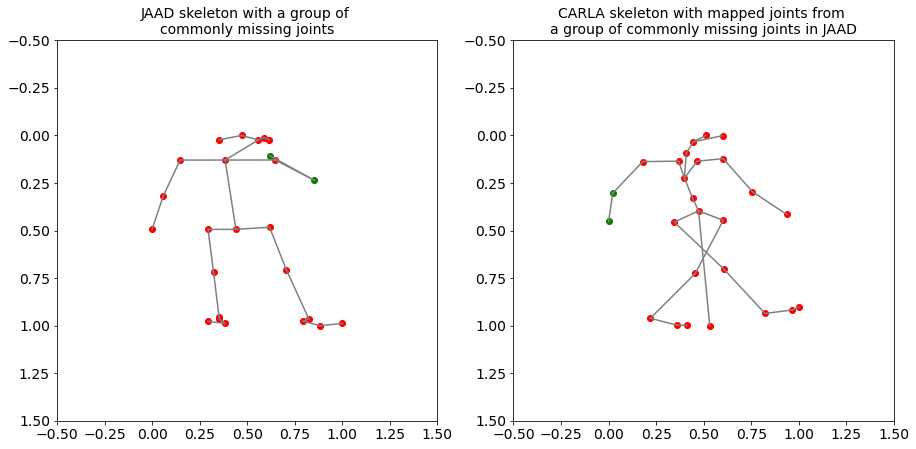

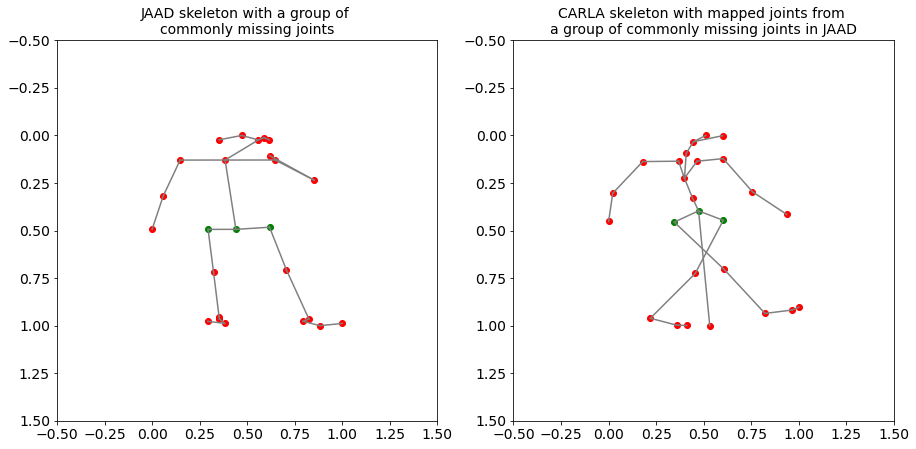

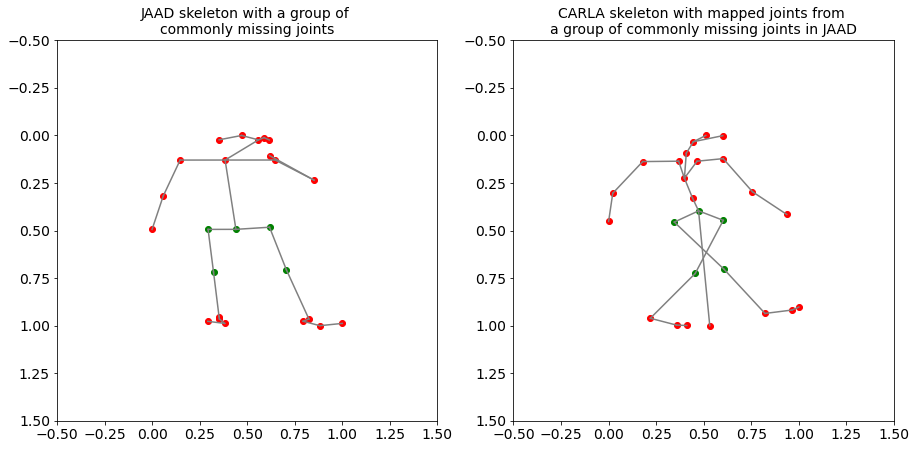

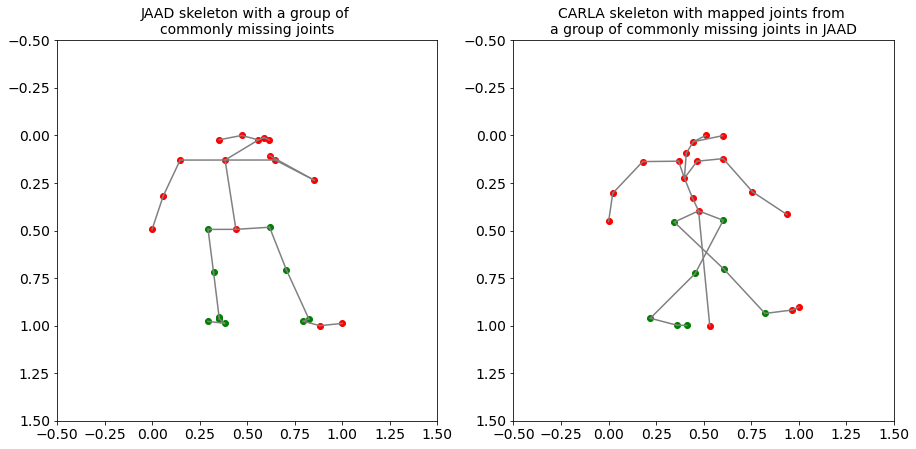

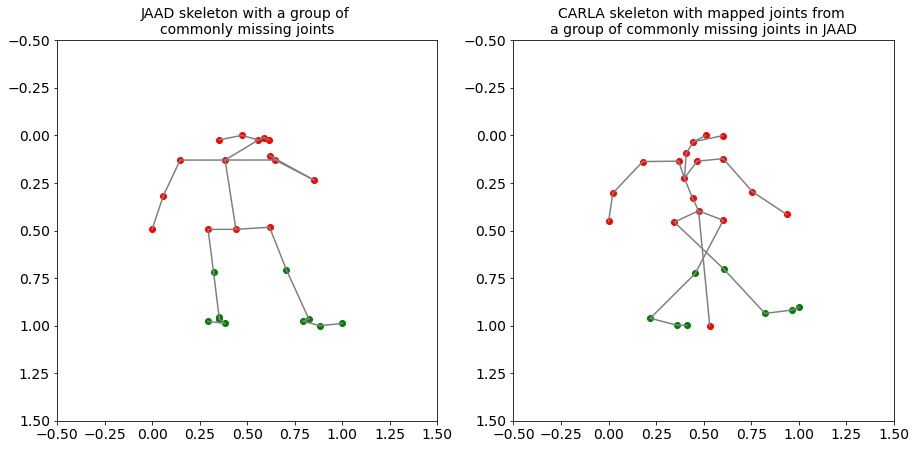

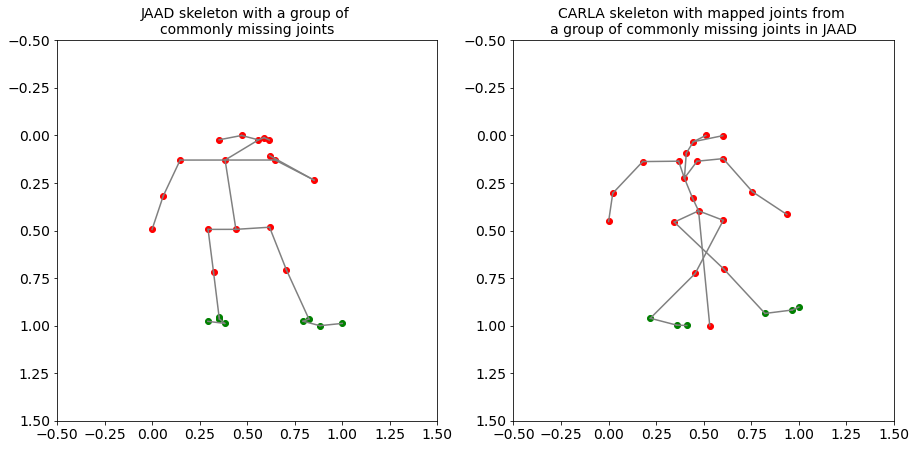

In [24]:
for group in groups:
    
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(1,2,1)
    showSkeleton(dataset, 20, frameImage=np.ones((2,2,3)), highlighted=group,
                 ax=ax1, showLegend=False, title='JAAD skeleton with a group of \ncommonly missing joints')

    ax2 = fig.add_subplot(1,2,2)
    showSkeleton(dataset_carla, 20, frameImage=np.ones((2,2,3)), highlighted=[map_jaad_to_carla[joint] for joint in group],
                 ax=ax2, showLegend=False, title='CARLA skeleton with mapped joints from \na group of commonly missing joints in JAAD')

### The skeletons of the different groups of missing joints mapped to CARLA:

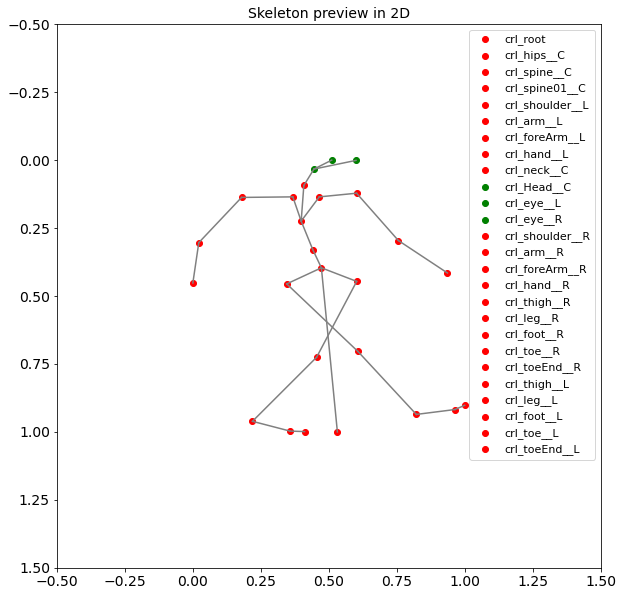

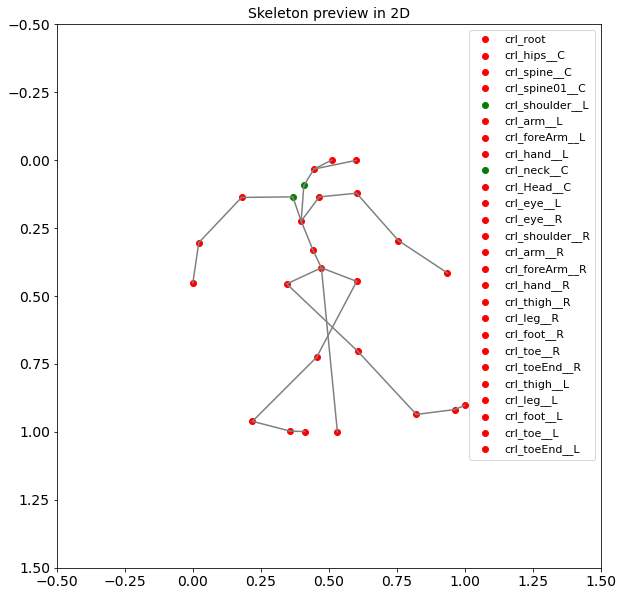

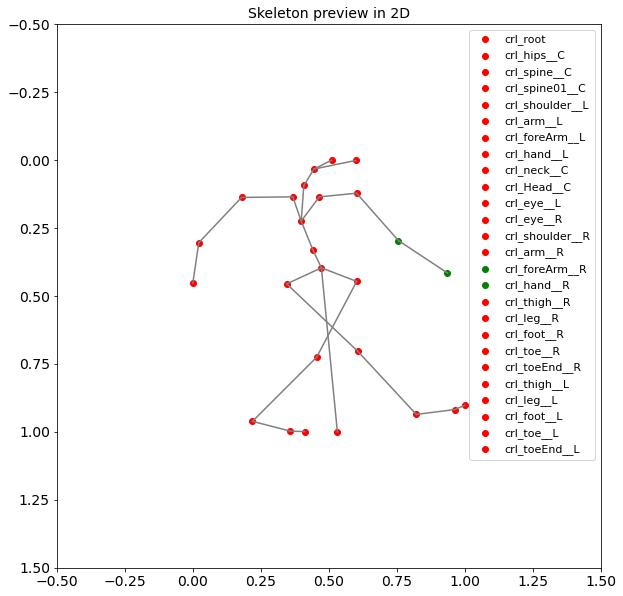

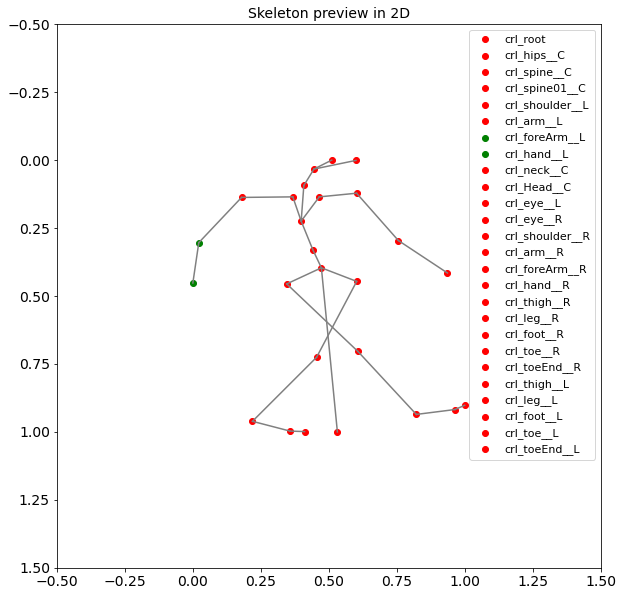

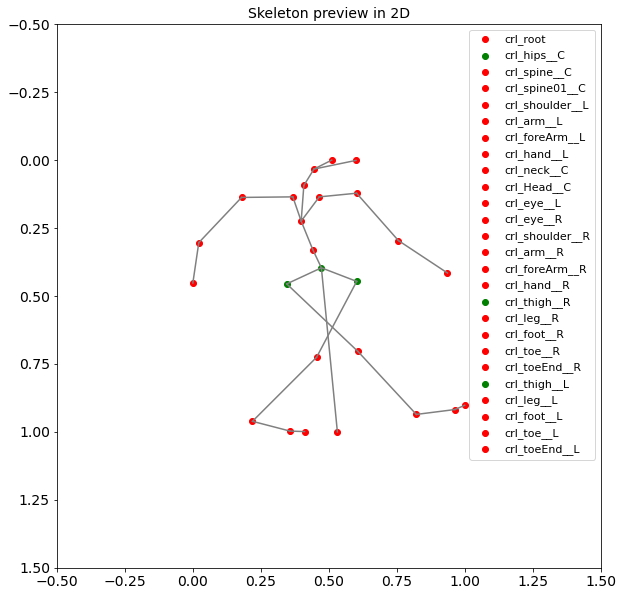

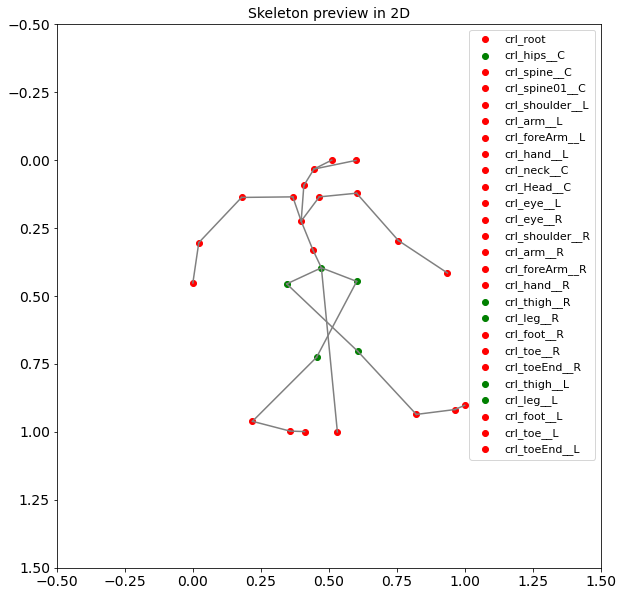

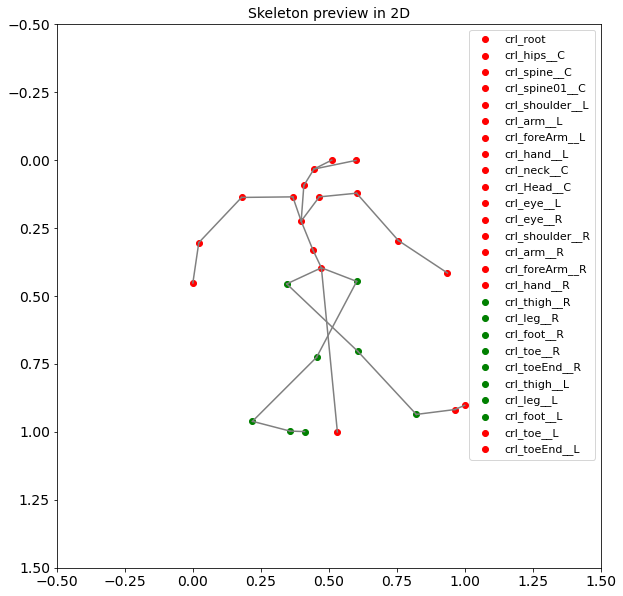

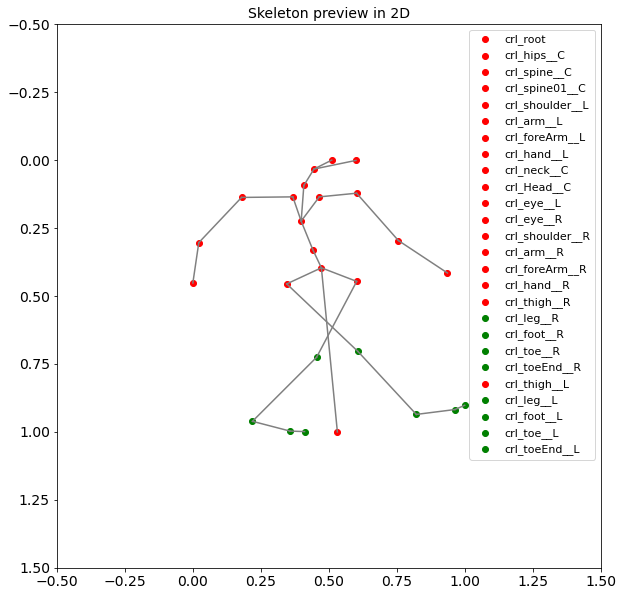

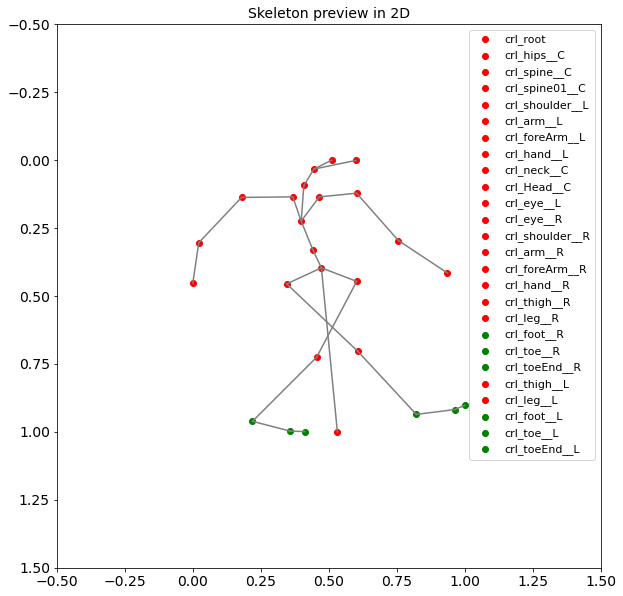

In [25]:
for group in groups:
    showSkeleton(dataset_carla, 20, frameImage=np.ones((2,2,3)), highlighted=[map_jaad_to_carla[joint] for joint in group])

#### Name of the CARLA mapped joints for each group of missing joints in JAAD:

In [26]:
groups_carla = [[map_jaad_to_carla[joint] for joint in group] for group in groups]
groups_carla

[['crl_Head__C', 'crl_eye__R', 'crl_eye__L'],
 ['crl_neck__C', 'crl_shoulder__L'],
 ['crl_foreArm__R', 'crl_hand__R'],
 ['crl_foreArm__L', 'crl_hand__L'],
 ['crl_hips__C', 'crl_thigh__R', 'crl_thigh__L'],
 ['crl_hips__C', 'crl_thigh__R', 'crl_leg__R', 'crl_thigh__L', 'crl_leg__L'],
 ['crl_thigh__R',
  'crl_leg__R',
  'crl_foot__R',
  'crl_thigh__L',
  'crl_leg__L',
  'crl_foot__L',
  'crl_foot__L',
  'crl_toe__R',
  'crl_toeEnd__R',
  'crl_foot__R'],
 ['crl_leg__R',
  'crl_foot__R',
  'crl_leg__L',
  'crl_foot__L',
  'crl_toe__L',
  'crl_toeEnd__L',
  'crl_foot__L',
  'crl_toe__R',
  'crl_toeEnd__R',
  'crl_foot__R'],
 ['crl_foot__R',
  'crl_foot__L',
  'crl_toe__L',
  'crl_toeEnd__L',
  'crl_foot__L',
  'crl_toe__R',
  'crl_toeEnd__R',
  'crl_foot__R']]